# Uma Análise da Ocupação Hospitalar no Brasil Durante a Pandemia de COVID-19 em 2020

> Dados obtidos em 17/04/2023

>**Aviso**: Por causa da forma como um notebook é renderizado no GitHub, várias funcionalidades não podem ser utilizadas. Os links do sumário, por exemplo, não redirecionam para a posição correta. Para contornar o problema, [este link]() direciona para outro serviço, *onde o notebook é renderizado de maneira mais apropriada*, facilitando muito a leitura. *--o link real será disponibilizado quando a análise estiver completa--*

## - - - - *em progresso* - - - -


- Data Wrangling -> **completo**
- Correções -> **competo**
- Visualização -> *em progresso*

Utilizando dados fornecidos pelo Ministério da Saúde, iremos analisar as **variações na _ocupação hospitalar_ nos estados brasileiros, com foco em _ocorrências de COVID-19 em 2020_.**
Os conjuntos de dados para cada ano podem ser baixados no formato `.csv` através deste [link](https://dados.gov.br/dados/conjuntos-dados/registro-de-ocupacao-hospitalar-covid-19). O link anterior redireciona para uma página específica dentro do **[Portal Brasileiro de Dados Abertos](https://dados.gov.br/home)**

No entanto, **não há documentação disponível**. As únicas informações disponibilizadas a respeito dos dados são:
>"O módulo Internações foi desenvolvido para registro da ocupação de leitos clínicos e de Unidade de Terapia Intensiva (UTI) SUS destinados para atendimento aos pacientes com casos suspeitos ou confirmados da COVID-19 (ocupação SRAG / COVID-19)"

e também:

>"A partir do ano de 2022 foram acrescentado novos campos utilizados para descrever a ocupação dos leitos. Registros com ano anterior a 2022 não contém esses campos preenchidos."

Pela falta de informações sobre os dados obtidos, precisamos entender melhor o que cada item significa. Por este motivo a seção [Data Wrangling](#1) será bastante extensa. Sabendo disso, pode ser melhor separar a análise em etapas mais independentes.

Sendo assim, o que seria a seção de *Introdução* estará junto com a etapa de [Visualização / Discussão](#11). Dessa forma, caso seja de interesse, fica mais fácil navegar pelo arquivo pulando alguma etapa. O **Sumário** destaca os pontos mais importantes. *Clique nos títulos e a página será direcionada para a seção escolhida*.

## Sumário

* **[Data Wrangling](#1)**
  * [Visão Geral](#2)
  * [Deduzindo Colunas](#3)
  * [Consideração Sobre o Escopo da Análise](#4)
  * [Identificando Anomalias](#5)
    * [Busca por Dados Adicionais](#6)
  * [Substituíndo Dados Anômalos](#7)
  * [Imputando Dados](#8)
  * [Otimizando o Armazenamento](#9)
  * [Reduzindo o Arquivo](#10)
  * [Criando Colunas Calculadas](#11)
  * [Correções Necessárias](#12)
    * [Solução para o Problema](#12-a)
    * [Aplicando a Solução](#12-b)
* **[Visualização / Discussão](#13)**
  * [Planilhas](#14)
    * [Excel](#14-1)
    * [Google Sheets](#14-2)
  * [Seaborn](#15)

# Data Wrangling<a id="1"></a>

## Visão Geral<a id="2"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from datetime import date
import warnings

In [2]:
df = pd.read_csv('ocupacao-leito-2020.csv')

/tmp/ipykernel_41219/2661094983.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ocupacao-leito-2020.csv')


Já somos recebidos com um aviso indicando que há uma coluna com tipos de dados misturados, mas vamos além para investigar o restante e conhecer melhor nosso material de análise.

Para isso será útil verificar uma amostra do conjunto de dados e listar todas as colunas junto com seus respectivos tipos de dados.

In [3]:
df.head()

,Unnamed: 0,_id,dataNotificacao,cnes,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,ocupacaoCovidUti,ocupacaoCovidCli,...,origem,_p_usuario,estadoNotificacao,municipioNotificacao,estado,municipio,excluido,validado,_created_at,_updated_at
0,0,p5Ez41Zu6B,2020-04-14T03:00:00.000Z,2303167,0.0,0.0,0.0,0.0,NaN,NaN,...,aplicacao-web,_User$auVMjEVEVz,Santa Catarina,Itapema,Santa Catarina,Itapema,True,False,2020-04-15T13:44:30.085Z,2020-04-16T13:56:13.656Z
1,1,eUOMsSt7T7,2020-04-15T03:00:00.000Z,5935377\t,1.0,0.0,0.0,0.0,NaN,NaN,...,parse-cloud,_User$WBa5nfe9P9,Rio de Janeiro,Rio de Janeiro,Rio de Janeiro,Rio de Janeiro,False,False,2020-04-15T13:50:47.256Z,2020-08-01T20:08:13.116Z
2,2,QaG4oIBrMa,2020-04-15T14:57:16.255Z,0012599,15.0,1.0,3.0,2.0,NaN,NaN,...,parse-cloud,_User$6oxZQHBPQ7,Rio de Janeiro,Niterói,Rio de Janeiro,Niterói,False,False,2020-04-15T15:20:57.033Z,2020-08-01T20:02:12.729Z
3,3,ifya31F3ZF,2020-03-24T03:00:00.000Z,2562871,9.0,0.0,1.0,0.0,NaN,NaN,...,parse-cloud,_User$fhufIbmR9C,Ceará,Várzea Alegre,Ceará,Várzea Alegre,False,False,2020-04-15T16:58:32.839Z,2020-08-01T21:40:37.624Z
4,4,dkurDhelx9,2020-04-01T03:00:00.000Z,2252228,26.0,0.0,1.0,0.0,NaN,NaN,...,parse-cloud,_User$tkAdHTNhC9,Rio Grande do Sul,Encantado,Rio Grande do Sul,Encantado,False,False,2020-04-15T17:02:53.877Z,2020-08-01T21:37:53.664Z


In [4]:
df.dtypes

Unnamed: 0                 int64
_id                       object
dataNotificacao           object
cnes                      object
ocupacaoSuspeitoCli      float64
ocupacaoSuspeitoUti      float64
ocupacaoConfirmadoCli    float64
ocupacaoConfirmadoUti    float64
ocupacaoCovidUti         float64
ocupacaoCovidCli         float64
ocupacaoHospitalarUti    float64
ocupacaoHospitalarCli    float64
saidaSuspeitaObitos      float64
saidaSuspeitaAltas       float64
saidaConfirmadaObitos    float64
saidaConfirmadaAltas     float64
origem                    object
_p_usuario                object
estadoNotificacao         object
municipioNotificacao      object
estado                    object
municipio                 object
excluido                    bool
validado                    bool
_created_at               object
_updated_at               object
dtype: object

## Deduzindo Colunas<a id="3"></a>

### `cnes` e valores privados *(`_...`)*

A coluna sobre a qual recebemos o aviso se trata de `cnes`, referente ao *Cadastro Nacional de Estabelecimentos de Saúde*. Pelo que é possível verificar, deveriamos ver apenas números, mas aparentemente existem erros de digitação inserindo caractéres em alguns registros.

Além disso, é possível verificar alguns campos iniciados com "**_**", que geralmente indicam *variáveis privadas voltadas para uso interno de alguma aplicação*. **Possivelmente não acrescentarão muito para a análise**, mas é importante verificar se de fato podemos excluí-los sem perdas.

Analisando os primeiros registros é possível notar que `_created_at` parece ser a data em que o registro foi criado. Muitos deles são feitos em sequência num *curto período de tempo*, adicionando registros `dataNotificacao` de datas passadas. 

`_updated_at` apresenta padrão semelhante (inserção em lotes), provavelmente gerando uma análise desconexa. Logo, `dataNotificacao` seria a infomação efetivamente útil para nossa análise. 

`_p_usuario` proavelmente se refere ao 'id' do usuário que inseriu o registro, enquanto `_id` possivelmente se trata do identificador do registro em si. Podemos verificar se a quantidade de `_id` únicos é igual ao número total de registros.

In [5]:
shape = df.shape
shape[0] == len(df['_id'].unique())

True

`_id` é mesmo o que imaginamos. A propósito, podemos aproveitar e conferir com quantos registros estamos lidando:

In [6]:
print(f"Nosso DataFrame possui {shape[0]} linhas e {shape[1]} colunas")

Nosso DataFrame possui 554687 linhas e 26 colunas


Vamos começar a listar todas as colunas que não terão utilidade para a análise.

In [7]:
to_drop = ['_id', '_p_usuario', '_created_at', '_updated_at']

### Campos Novos - *Utilizados apenas a partir de 2022*

Agora podemos prosseguir para as demais colunas. 

Logo de início podemos notar que nas 5 primeiras linhas, todos os registros de `ocupacaoCovidUti` e `ocupacaoCovidCli` não estão preenchidos. Será que isso se mantém para todo o documento?

In [8]:
df['ocupacaoCovidUti'].value_counts()

ocupacaoCovidUti
 0.0     336
 20.0     67
 19.0     41
 1.0      21
 18.0     16
 2.0       5
 3.0       4
 17.0      3
 10.0      3
 6.0       3
 7.0       2
 5.0       2
 4.0       1
-1.0       1
 8.0       1
 44.0      1
 22.0      1
 25.0      1
 23.0      1
 11.0      1
Name: count, dtype: int64

Dos mais de 550 mil registros no documento, na coluna `ocupacaoCovidUti` somente cerca de 500 possuem um valor válido (incluindo um valor negativo).

Por padrão, o método `.head()` não mostra todas as colunas, então é possível que além de `ocupacaoCovidUti` e `ocupacaoCovidCli` outras colunas apresentem o mesmo padrão. 

Mesmo que este arquivo seja referente ao ano 2020, vimos que existe um campo específico para data de *atualização do registro*. Além disso, segundo a fonte, *registros a partir de 2022 possuem novos campos*. Dessa maneira, **é possível que dados atualizados depois de 2022 apresentem inconsistências**.

Podemos começar a investigar essa hipótese verificando melhor as estatísticas descritivas.

In [9]:
df.describe()

,Unnamed: 0,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,ocupacaoCovidUti,ocupacaoCovidCli,ocupacaoHospitalarUti,ocupacaoHospitalarCli,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,saidaConfirmadaAltas
count,5.546870e+05,5.542860e+05,554286.000000,554287.000000,554287.000000,511.000000,511.000000,511.000000,511.000000,554571.000000,5.545830e+05,554675.000000,5.546740e+05
mean,2.802098e+05,1.901152e+02,7.139670,6.081243,4.477320,5.301370,4.651663,7.043053,22.080235,0.224539,5.138644e+01,0.373017,3.395598e+01
std,1.677398e+05,6.208808e+04,16.098472,33.178988,11.254881,8.597718,5.848411,12.397110,51.228089,3.571056,3.766872e+04,3.744652,1.729309e+04
min,0.000000e+00,-5.700000e+01,-9.000000,-10.000000,-7.000000,-1.000000,0.000000,0.000000,0.000000,-10.000000,-1.200000e+01,-3.000000,-1.300000e+01
25%,1.387045e+05,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
50%,2.773850e+05,4.000000e+00,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,8.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
75%,4.160795e+05,2.700000e+01,8.000000,6.000000,5.000000,17.500000,10.000000,20.000000,11.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
max,1.618772e+06,2.908202e+07,924.000000,22222.000000,334.000000,44.000000,60.000000,195.000000,314.000000,425.000000,2.805202e+07,322.000000,9.112020e+06


Constatamos exatamente 511 registros nas colunas `ocupacaoCovidUti`, `ocupacaoCovidCli`, `ocupacaoHospitalarUti`, `ocupacaoHospitalarCli`, o que corrobora para nossa hipótese de registros atualizados depois de 2022.

Para confirmar, podemos averiguar as datas de atualização dos registros de qualquer um dos 4 campos em questão.

In [10]:
df.loc[df['ocupacaoCovidUti'].notnull(), '_updated_at'].sort_values()

167280    2021-08-04T17:51:01.154Z
313270    2021-08-04T17:51:06.834Z
554199    2021-08-10T03:01:39.990Z
554200    2021-08-10T03:01:40.313Z
554201    2021-08-10T03:01:40.417Z
                    ...           
554682    2023-02-15T19:28:39.477Z
554683    2023-03-08T12:03:10.135Z
554684    2023-04-06T14:28:58.666Z
554685    2023-04-12T12:57:54.509Z
554686    2023-04-12T12:58:12.391Z
Name: _updated_at, Length: 511, dtype: object

Considerando os 511 registros contestados, a atualização mais antiga ocorreu em 04/08/**2021**, e a mais recente em 12/04/**2023**. *Não comprova nossa hipótese com certeza*, mas avaliando pelo período coberto pelos registros *(fim de 2021 até começo de 2023)*, pode-se dizer que há um certo *indício* de que registros com `_updated_at` mais recentes sejam problemáticos. 

Como não temos o conhecimento exato da informação que cada campo nos traz, a julgar pelo nome das colunas, parecem se tratar de *informações objetivamente diferentes*. Ainda, suas estatísticas não parecem diferir muito do resto do conjunto. Com essas considerações, *junto com o fato de representarem cerca de 0,09% dos dados*, acredito que seja melhor não incluí-las na análise.

Em vez de adicionarmos à primeira lista de remoção `to_drop`, vamos armazená-las em uma outra lista. Faremos isso pois irão ser removidas em etapas diferentes para facilitar nossa próxima análise das estatísticas descritivas.

In [11]:
to_drop_numeric = ['ocupacaoCovidUti', 'ocupacaoCovidCli', 'ocupacaoHospitalarUti', 'ocupacaoHospitalarCli']

### `Unnamed: 0`

Aproveitando a criação de uma lista especial para dados numéricos, vamos checar a coluna `Unnamed: 0`.

Sendo do tipo `int64`, aparentemente se trata de um **índice**, identificando cada coluna do DataFrame com um número único. Podemos confirmar fazendo a contagem de valores únicos na coluna e comparando com o total de linhas do DataFrame.

In [12]:
len(df['Unnamed: 0'].unique()) == df.shape[0]

True

As quantidades bateram, o que comprova nossa hipótese. Aqui temos duas opções, incluir `Unnamed:  0` na lista para remoção ou usá-la como índice.

Como carregamos o arquivo *sem indicar* uma coluna para servir de índice, Pandas criou uma *automaticamente* no momento do carregamento. Já que efetivamente estamos apenas com algo **duplicado**, podemos optar pela remoção.

In [13]:
to_drop_numeric.append('Unnamed: 0')

### `origem`, `excluido` e `validado`

O campo `origem` aparentemente indica a forma com que os dados foram coletados ou processados. Para ter mais certeza, podemos verificar quais os valores encontrados.

In [14]:
df['origem'].unique()

array(['aplicacao-web', 'parse-cloud', 'RPA-SP', 'RPA-CE', 'RPA-RS',
       'RPA-MS', 'RPA-GO', 'RPA-MT', 'RPA-RN', 'RPA-PR', 'RPA-MG',
       'RPA-MG-BELO-HORIZONTE', 'RPA-PR-CURITIBA'], dtype=object)

"RPA" provavelmente se refere à "Robotic Process Automation", enquanto "parse-cloud" pode se referir a um serviço de nuvem que faz a análise sintática (parsing) dos dados. De toda maneira, não é algo que será levado em consideração na análise de ocupação hospitalar.

In [15]:
to_drop.append('origem')

Veremos agora o que `excluido` e `validado` podem nos mostrar.

In [16]:
df['excluido'].value_counts()

excluido
False    554182
True        505
Name: count, dtype: int64

In [17]:
df.loc[df['excluido'] == True]


,Unnamed: 0,_id,dataNotificacao,cnes,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,ocupacaoCovidUti,ocupacaoCovidCli,...,origem,_p_usuario,estadoNotificacao,municipioNotificacao,estado,municipio,excluido,validado,_created_at,_updated_at
0,0,p5Ez41Zu6B,2020-04-14T03:00:00.000Z,2303167,0.0,0.0,0.0,0.0,NaN,NaN,...,aplicacao-web,_User$auVMjEVEVz,Santa Catarina,Itapema,Santa Catarina,Itapema,True,False,2020-04-15T13:44:30.085Z,2020-04-16T13:56:13.656Z
31,31,tv1uXbMbdc,2020-04-15T17:23:44.000Z,2240335,20.0,5.0,0.0,0.0,NaN,NaN,...,aplicacao-web,_User$Enseqp32PQ,Rio Grande do Sul,Farroupilha,Rio Grande do Sul,Farroupilha,True,False,2020-04-15T17:24:00.316Z,2020-04-15T17:35:07.999Z
62,62,fHqEA6b8Xt,2020-04-15T19:18:27.505Z,2375850,0.0,0.0,0.0,10.0,NaN,NaN,...,aplicacao-web,_User$Utr4cDP5eD,Mato Grosso do Sul,Paranaíba,Mato Grosso do Sul,Paranaíba,True,False,2020-04-15T19:29:13.561Z,2020-04-15T19:48:07.806Z
70,70,Zekk3kC7Gp,2020-04-01T03:00:00.000Z,2760819,1.0,0.0,0.0,0.0,NaN,NaN,...,aplicacao-web,_User$cIStY25tjj,Minas Gerais,Minduri,Minas Gerais,Minduri,True,False,2020-04-15T19:38:08.434Z,2020-04-15T19:49:49.157Z
72,72,6m0iH5blyQ,2020-04-02T03:00:00.000Z,2760819,1.0,0.0,0.0,0.0,NaN,NaN,...,aplicacao-web,_User$cIStY25tjj,Minas Gerais,Minduri,Minas Gerais,Minduri,True,False,2020-04-15T19:39:52.298Z,2020-04-15T19:50:00.013Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19617,19621,JO81FFRtz8,2020-05-11T13:11:48.671Z,2436450,133.0,28.0,9.0,8.0,NaN,NaN,...,aplicacao-web,_User$1XfNU4qbhz,Santa Catarina,Joinville,Santa Catarina,Joinville,True,False,2020-05-11T13:20:38.299Z,2020-05-12T11:09:21.900Z
19618,19622,EACElG3PDS,2020-05-11T13:11:48.671Z,2436450,133.0,28.0,9.0,8.0,NaN,NaN,...,aplicacao-web,_User$1XfNU4qbhz,Santa Catarina,Joinville,Santa Catarina,Joinville,True,False,2020-05-11T13:21:46.909Z,2020-05-12T11:09:30.965Z
19619,19623,S63bzGI2iK,2020-05-11T13:11:48.671Z,2436450,133.0,28.0,9.0,8.0,NaN,NaN,...,aplicacao-web,_User$1XfNU4qbhz,Santa Catarina,Joinville,Santa Catarina,Joinville,True,False,2020-05-11T13:20:47.607Z,2020-05-12T11:10:07.500Z
19813,19821,OZzcvODn1G,2020-05-11T15:38:05.414Z,2436450,133.0,28.0,9.0,8.0,NaN,NaN,...,aplicacao-web,_User$1XfNU4qbhz,Santa Catarina,Joinville,Santa Catarina,Joinville,True,False,2020-05-11T15:40:22.575Z,2020-05-12T11:09:17.290Z


Apesar de não haver documentação disponível, o nome da coluna em si (`excluido`) já indica fortemente que os registros marcados como verdadeiros não são aptos para uso nessa análise. 

Encontramos **505 registros** marcados, e destes podemos notar algumas particularidades como: 

Registros `dataNotificacao` exatamente iguais *(com precisão de 0,001 segundos)* para a mesma `cnes` e feitos pelo mesmo `_p_usuario`, vários deles com dados idênticos em `ocupacaoSuspeitoCli`, `ocupacaoSuspeitoUti`, `ocupacaoConfirmadoCli`, `ocupacaoConfirmadoUti`.

In [18]:
df.loc[(df['excluido'] == True) & (df.duplicated(subset=['dataNotificacao']))]

,Unnamed: 0,_id,dataNotificacao,cnes,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,ocupacaoCovidUti,ocupacaoCovidCli,...,origem,_p_usuario,estadoNotificacao,municipioNotificacao,estado,municipio,excluido,validado,_created_at,_updated_at
70,70,Zekk3kC7Gp,2020-04-01T03:00:00.000Z,2760819,1.0,0.0,0.0,0.0,NaN,NaN,...,aplicacao-web,_User$cIStY25tjj,Minas Gerais,Minduri,Minas Gerais,Minduri,True,False,2020-04-15T19:38:08.434Z,2020-04-15T19:49:49.157Z
72,72,6m0iH5blyQ,2020-04-02T03:00:00.000Z,2760819,1.0,0.0,0.0,0.0,NaN,NaN,...,aplicacao-web,_User$cIStY25tjj,Minas Gerais,Minduri,Minas Gerais,Minduri,True,False,2020-04-15T19:39:52.298Z,2020-04-15T19:50:00.013Z
73,73,J6qrjnb2y4,2020-04-03T03:00:00.000Z,2760819,1.0,0.0,0.0,0.0,NaN,NaN,...,aplicacao-web,_User$cIStY25tjj,Minas Gerais,Minduri,Minas Gerais,Minduri,True,False,2020-04-15T19:41:13.629Z,2020-04-15T19:50:20.836Z
74,74,84u09qrCH4,2020-04-04T03:00:00.000Z,2760819,0.0,0.0,0.0,0.0,NaN,NaN,...,aplicacao-web,_User$cIStY25tjj,Minas Gerais,Minduri,Minas Gerais,Minduri,True,False,2020-04-15T19:41:51.378Z,2020-04-15T19:50:07.477Z
186,186,lMXoydTmd1,2020-04-14T03:00:00.000Z,2418967,25.0,0.0,2.0,0.0,NaN,NaN,...,aplicacao-web,_User$1aBS46RcA0,Santa Catarina,São João Batista,Santa Catarina,São João Batista,True,False,2020-04-15T20:24:50.502Z,2020-04-15T21:42:10.108Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13772,13776,deIHZTOWsU,2020-04-02T03:00:00.000Z,0105724,0.0,0.0,0.0,0.0,NaN,NaN,...,aplicacao-web,_User$QtAd4NBwBc,Paraná,Corbélia,Paraná,Corbélia,True,False,2020-05-04T20:25:54.924Z,2020-05-04T20:26:32.391Z
18500,18504,8tidqNgXtv,2020-05-09T17:30:23.940Z,2436450,117.0,20.0,9.0,8.0,NaN,NaN,...,aplicacao-web,_User$1XfNU4qbhz,Santa Catarina,Joinville,Santa Catarina,Joinville,True,False,2020-05-09T18:34:15.464Z,2020-05-12T11:09:58.154Z
19618,19622,EACElG3PDS,2020-05-11T13:11:48.671Z,2436450,133.0,28.0,9.0,8.0,NaN,NaN,...,aplicacao-web,_User$1XfNU4qbhz,Santa Catarina,Joinville,Santa Catarina,Joinville,True,False,2020-05-11T13:21:46.909Z,2020-05-12T11:09:30.965Z
19619,19623,S63bzGI2iK,2020-05-11T13:11:48.671Z,2436450,133.0,28.0,9.0,8.0,NaN,NaN,...,aplicacao-web,_User$1XfNU4qbhz,Santa Catarina,Joinville,Santa Catarina,Joinville,True,False,2020-05-11T13:20:47.607Z,2020-05-12T11:10:07.500Z


Muitos registros de fato seguem o padrão que identificamos. Provavelmente são registros desatualizados ou com algum tipo de inconsistência.

Além do nome sugestivo da coluna, obtivemos várias informações que nos permitem ser **assertivos na eliminação de todos os registros em que `excluido` = `True`**. Como após a exclusão a coluna não terá mais serventia, podemos também eliminá-la dos dados para análise.

In [19]:
df.drop(df.loc[df['excluido'] == True].index, inplace=True)

In [20]:
to_drop.append('excluido')

Agora vejamos `validado`:

In [21]:
df['validado'].value_counts()

validado
False    554182
Name: count, dtype: int64

Todos os registros estão marcados como `False`, o que nos impossibilita buscar por padrões para inferir o que de fato a coluna significa.

Em busca de mais informações, encontrei outro [local onde o mesmo conjunto de dados é disponibilizado](https://opendatasus.saude.gov.br/dataset/registro-de-ocupacao-hospitalar-covid-19), o *OpenDataSUS*. Verifiquei que tanto o [Portal Brasileiro de Dados Abertos](https://dados.gov.br/home) *(onde obtivemos os dados)* quanto o [OpenDataSUS](https://opendatasus.saude.gov.br/) **apontam para o mesmo [URL](https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/LEITOS/2023-04-21/esus-vepi.LeitoOcupacao_2020.csv)** 
> *(o arquivo está armazenado em um bucket S3 da Amazon. Clicar no link 'URL' inicia o download)*. 

Ou seja, tanto um quanto outro nos fornecem o **mesmo arquivo**. Logo, qualquer informação encontrada em ambos endereços é igualmente válida para os dados obtidos.

No OpenDataSUS temos algumas [informações adicionais](https://opendatasus.saude.gov.br/dataset/registro-de-ocupacao-hospitalar-covid-19/resource/a16c8d5f-dc6d-46c8-8e75-41765a18a289) sobre o conjunto de dados em si. Temos informações como data de criação, **status de atividade** e **data da última modificação** *(a última presente em ambos)*. 

* Estado: ativo
* Dados atualizados pela última vez: 22/04/2023 *(dia em que foi feita a verificação)*

Também podemos encontrar registros do [fluxo de atividade](https://opendatasus.saude.gov.br/dataset/activity/registro-de-ocupacao-hospitalar-covid-19). Aqui vemos que os dados são **atualizados diariamente**.

Sabendo que se trata de um arquivo atualizado e mantido sob cuidado diário, podemos concluir que os dados em que estamos trabalhando são utilizáveis, ainda que o campo `validado` possa nos induzir a supor o contrário.

Dessa maneira, como todos os registros do arquivo possuem o mesmo valor, nada é agregado à análise. Iremos apenas *descartar a coluna*.

In [22]:
to_drop.append('validado')

### `municipio` / `municipioNotificacao`, `estado` / `estadoNotificacao`

Ainda nos restam as colunas `municipio`, `estado`, `municipioNotificacao`, `estadoNotificacao`. Vamos apenas conferir se os "pares" (ex: `estado` / `estadoNotificacao`) contém o mesmo conteúdo.

In [23]:
len(df['estado'].unique()) == len(df['estadoNotificacao'].unique())

False

In [24]:
len(df['estado']) == len(df['estadoNotificacao'])

True

Há algo de diferente aqui.

Apesar de possuirem o mesmo número de registros, temos diferentes quantidade de valores únicos.

In [25]:
print(df['estado'].unique())

['Rio de Janeiro' 'Ceará' 'Rio Grande do Sul' 'Santa Catarina'
 'Minas Gerais' 'Pará' 'Piauí' 'Mato Grosso do Sul' 'Goiás' 'Rondônia'
 'Acre' 'Amazonas' 'Pernambuco' 'Paraná' 'Maranhão' 'Bahia' 'São Paulo'
 'Paraíba' 'Alagoas' 'Mato Grosso' 'Sergipe' 'Distrito Federal'
 'Tocantins' 'Rio Grande do Norte' nan 'Amapá' 'Espírito Santo' 'Roraima'
 'GOIAS']


In [26]:
print(df['estadoNotificacao'].unique())

['Rio de Janeiro' 'Ceará' 'Rio Grande do Sul' 'Santa Catarina'
 'Minas Gerais' 'Pará' 'Piauí' 'Mato Grosso do Sul' 'Goiás' 'Rondônia'
 'Acre' 'Amazonas' 'Pernambuco' 'Paraná' 'Maranhão' 'Bahia' 'São Paulo'
 'Paraíba' 'Alagoas' 'Mato Grosso' 'Sergipe' 'Distrito Federal'
 'Tocantins' 'Rio Grande do Norte' 'Amapá' 'Espírito Santo' 'Roraima'
 'GOIAS']


Em ambos o estado de Goiás está registrado duas vezes. Como "Goiás" e "GOIAS". Isso será fácil de corrigir.

Mas vemos algo além. `estado` possui alguns campos listados como `nan` *("Not a Number" nesse contexto é referente a um campo nulo)*. Vamos verificar quais são esses registros.

In [27]:
df[df['estado'].isnull()]

,Unnamed: 0,_id,dataNotificacao,cnes,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,ocupacaoCovidUti,ocupacaoCovidCli,...,origem,_p_usuario,estadoNotificacao,municipioNotificacao,estado,municipio,excluido,validado,_created_at,_updated_at
4182,4184,bc66V3say8,2020-04-24T12:32:29.807Z,2246902,1.0,0.0,1.0,0.0,NaN,NaN,...,aplicacao-web,_User$Ow1jWbSgxK,Rio Grande do Sul,Não-Me-Toque,NaN,NaN,False,False,2020-04-24T12:33:53.952Z,2020-04-24T12:33:53.952Z


Apena um registro tem campos faltantes em `estado` e `municipio`. Porém seus "pares" contam esses dados.

In [28]:
df.drop(4182, inplace=True)

Poderiamos dar esse caso em particular como resolvido, no entanto, será que todos os outros "pares" apresentam as mesmas informações?

In [29]:
len(df.loc[df['estado'] == df['estadoNotificacao']]) == df.shape[0]

False

Aperentemente não. Vejamos o motivo:

In [30]:
df.loc[df['estado'] != df['estadoNotificacao'], ['cnes', 'municipio', 'estado' , 'municipioNotificacao', 'estadoNotificacao']]

,cnes,municipio,estado,municipioNotificacao,estadoNotificacao
931,2438313,Minaçu,Goiás,Itaobim,Minas Gerais
2962,703208645495691,Buritis,Rondônia,São Romão,Minas Gerais
33764,223505,Cassilândia,Mato Grosso do Sul,Ouro Preto do Oeste,Rondônia
121811,2786095.0,Dianópolis,Tocantins,Brasília,Distrito Federal
193605,4069803,Juína,Mato Grosso,Propriá,Sergipe
438983,2013029,Manaus,Amazonas,Tunápolis,Santa Catarina
478919,3004104,Manaus,Amazonas,Propriá,Sergipe
516046,2017555,Carauari,Amazonas,Codó,Maranhão


Vemos algo sem coerência. Poderíamos discutir sobre o significado de cada coluna. Porém, dificilmente teríamos certeza do que se tratam *(ex: residente de um estado sendo notificado em outro durante uma viagem)*. 

Dessa forma, será melhor excluir os registros da análise. Também poderíamos argumentar que 8 registros são uma parcela muito pequena do arquivo.

In [31]:
print(f"8 registros representam {100 * (8 / df.shape[0]):.4f}% do arquivo")

8 registros representam 0.0014% do arquivo


In [32]:
df.drop(df.loc[df['estado'] != df['estadoNotificacao']].index, inplace=True)

len(df.loc[df['estado'] == df['estadoNotificacao']]) == df.shape[0]

True

Agora `estado` e `estadoNotificacao` são idênticas, podemos utilizar tanto uma quanto outra. Iremos executar um processo parecido para `municipio` e `municipioNotificacao`.

In [33]:
print(f"Municípios únicos em 'municipio': {len(df['municipio'].unique())}\n\
Municípios únicos em 'municipioNotificacao': {len(df['municipioNotificacao'].unique())}")

Municípios únicos em 'municipio': 2260
Municípios únicos em 'municipioNotificacao': 2259


In [34]:
# qual registro em 'municipio' não está contido em 'municipioNotificacao'
set(df['municipio'].unique()) - set(df['municipioNotificacao'].unique())

{'Campina Grande do Sul'}

In [35]:
# DataFrame temporário onde 'municipio' e 'municipioNotificacao' não coincidem
df_notif_municipio = df.loc[df['municipio'] != df['municipioNotificacao']]
# número de registros
len(df_notif_municipio)

41

Vamos verificar se nos registros onde `municipio` é diferente de `municipioNotificacao` o `estado` também é diferente de `estadoNotificacao`.

In [36]:
df_notif_municipio.loc[df_notif_municipio['estado'] != df_notif_municipio['estadoNotificacao']]

,Unnamed: 0,_id,dataNotificacao,cnes,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,ocupacaoCovidUti,ocupacaoCovidCli,...,origem,_p_usuario,estadoNotificacao,municipioNotificacao,estado,municipio,excluido,validado,_created_at,_updated_at


Aparentemente todos os registros onde `municipio` e `municipioNotificacao` são diferentes não apresentam a mesma discrepância em relação ao estado. Ou seja, ainda que os dois registros relativos a municípios sejam *diferentes*, ambos estão dentro do **mesmo estado**.

Como nossa análise tem enfoque em *estados*, a inclusão de tais dados seria aceitável.

De toda maneira, se de alguma forma conseguíssemos localizar a origem real do registro teríamos um forte indicativo de qual coluna faz mais sentido para nós. Uma maneira de resolver isso seria *descobrir a localização de cada `cnes`*.

*Por enquanto, vamos deixar as coisas como estão*. Mais à frente iremos em busca de **outras fontes de dados** para conseguir mais **contexto** e utilizar melhor este arquivo. Como estaremos apenas aproveitando o trabalho, na pior hipótese podemos eleger uma das colunas para uso, e até mesmo excluir a coluna inutilizada para poupar armazenamento.

**Iremos retornar a este problema em um momento mais oportuno.**

No momento vamos *examinar* as informações que temos e *definir* algumas *prioridades*.

## Consideração Sobre o Escopo da Análise<a id="4"></a>



**Qual o escopo da análise?**

A idéia principal é de analisar o nível de ocupação hospitalar **em nível nacional**, portanto, talvez não seja interessante aumentarmos a *"resolução"* para municípios. Incorremos em **obscurecer nuances pelo exagero de detalhes**. *Quase como deixar de admirar a floresta por focar demais em uma só árvore.*

O que nos leva a considerar quais colunas são mais apropriadas e quais são menos compatíveis com o **objetivo da análise**.

Pelo menos em um primeiro momento, as informações mais relevantes seriam `estado`, `dataNotificacao`, `ocupcacaoSuspeitoCli`, `ocupacaoSuspeitoUti`, `ocupacaoConfirmadoCli`, `ocupacaoConfirmadoUti`, `saidaSuspeitaAltas`, `saidaSuspeitaObitos`, `saidaConfirmadaAltas`, `saidaConfirmadaObitos`. 

Campos como `municipio` e `cnes` entregam detalhes fora do escopo desta análise. Porém, além de ainda termos pendências com estes dados, são bons para análises subsequentes. Então, são informações que devem ser **preservadas**.

*Por exemplo, após verificarmos os estados mais e menos afetados, poderíamos usar estas informações para examiná-los com mais detalhes.*

In [37]:
print(f"No momento, o tamanho do nosso DataFrame é {(df.memory_usage().sum() / 10**6):.1f} Mb")

No momento, o tamanho do nosso DataFrame é 111.9 Mb


Temos algumas opções para separar os dados sobre municípios, incluindo bancos de dados relacionais para poupar armazenamento. 

No atual estado, o DataFrame tem aproximadamente 112 Mb. Não é um arquivo grande, mas de toda maneira, após a remoção das colunas marcadas o tamanho será consideravelmente reduzido. Quando fizermos isso, vamos considerar nossas opções.

Por último vamos apenas adicionar `estadoNotificacao` em nossa lista para remoção. *Como ainda não vasculhamos os municípios, vamos deixá-los como estão por enquanto*.

In [38]:
to_drop.append('estadoNotificacao')
print(to_drop)

['_id', '_p_usuario', '_created_at', '_updated_at', 'origem', 'excluido', 'validado', 'estadoNotificacao']


Estas são algumas das colunas que vamos eliminar. Iremos fazer isso em breve, no momento temos utilidade para elas.

## Identificando Anomalias<a id="5"></a>

Ainda precisamos averiguar os dados das **colunas numéricas**, e caso seja necessário, teremos que decidir como lidar com **dados anormais**.

Por isso havíamos separado as colunas para descarte em `to_drop` e `to_drop_numeric`. Colunas com variáveis categóricas *(`to_drop`)* trazem **contexto** para os registros, facilitando na decisão de **como lidar com valores faltantes**.

Já as numéricas irão apenas se confundir com as colunas que iremos de fato utilizar. Por isso agora serão removidas. 

In [39]:
df.drop(columns=to_drop_numeric, inplace=True)

Vamos novamente calcular as estatísticas descritivas.

In [40]:
df.describe()

,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,saidaConfirmadaAltas
count,5.537720e+05,553772.000000,553773.000000,553773.000000,554057.000000,5.540690e+05,554161.000000,5.541600e+05
mean,1.902687e+02,7.141221,6.084807,4.480354,0.224684,5.143359e+01,0.373303,3.398676e+01
std,6.211689e+04,16.092486,33.192898,11.258679,3.572660,3.768619e+04,3.746363,1.730111e+04
min,-5.700000e+01,-9.000000,-10.000000,-7.000000,-10.000000,-1.200000e+01,-3.000000,-1.300000e+01
25%,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
50%,4.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
75%,2.700000e+01,8.000000,6.000000,5.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
max,2.908202e+07,924.000000,22222.000000,334.000000,425.000000,2.805202e+07,322.000000,9.112020e+06


Em primeira vista podemos notar alguns pontos mais chamativos, como:
* **Outliers**
* **Valores mínimos negativos**
* **Diferentes quantidades de registros**

Algo que também pode nos causar problemas são **dados contínuos**. Podemos checar se existe alguma ocorrência realizando a somatória de alguma coluna *(ou todas)* e verificando se obtemos algum número fracionado. 

In [41]:
df['ocupacaoSuspeitoCli'].sum()

105365479.64199996

Temos de fato valores contínuos em um ou mais registros.

Assim sendo, **iremos percorrer todos os pontos citados.**

### Outliers

Como *29.082.020* parece um número exagerado de pacientes em um hospital, talvez seja um bom lugar para começar.

In [42]:
df['ocupacaoSuspeitoCli'].max()

29082020.0

Aqui temos um valor absolutamente fora da realidade. Na verdade parece um erro de digitação onde uma data foi inserida *(provavelmente 29/08/2020)*. De toda maneira, *não podemos saber qual seria o valor real*, então iremos considerar como outlier que deve ser seguramente descartado.

Vemos outro valor da mesma ordem em `saidaSuspeitaAltas`, então talvez seja prudente averiguar ocorrências semelhantes.

#### Dados Adicionais<a id="6"></a>

Temos nossa hipótese do motivo do erro, mas talvez precisemos de **mais contexto** em relação à capacidade real de hospitais brasileiros. Isso se soma à necessidade que encontramos lidando com `municipio` e `municipioNotificacao`.  

Convenientemente, o [Portal Brasileiro de Dados Abertos](https://dados.gov.br/home) possui recursos que vão nos ajudar em **ambos casos**. Temos dados sobre [hospitais e leitos](https://dados.gov.br/dados/conjuntos-dados/hospitais-e-leitos) divididos por anos. E para nossa sorte esses dados possuem [documentação](https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/Leitos_SUS/Dicion%C3%A1rio_Leito_hospitalar.pdf).

Para referência, a partir de agora vamos chamar nosso primeiro DataFrame *(dados sobre ocupação de leitos)* de "`ocupação`", e o segundo *(dados sobre hospitais e leitos em si)* de "`leitos`".

In [43]:
df_leitos = pd.read_csv('leitos-2020.csv')
df_leitos.head()

,COMP,REGIAO,UF,MUNICIPIO,MOTIVO DESABILITACAO,CNES,NOME ESTABELECIMENTO,RAZAO SOCIAL,TP_GESTAO,CO_TIPO_UNIDADE,...,UTI ADULTO - EXIST,UTI ADULTO - SUS,UTI PEDIATRICO - EXIST,UTI PEDIATRICO - SUS,UTI NEONATAL - EXIST,UTI NEONATAL - SUS,UTI QUEIMADO - EXIST,UTI QUEIMADO - SUS,UTI CORONARIANA - EXIST,UTI CORONARIANA - SUS
0,202001,NORDESTE,PE,CABO DE SANTO AGOSTINHO,NaN,27,CASA DE SAUDE SANTA HELENA,CASA DE SAUDE E MATERNIDADE SANTA HELENA LTDA,M,5,...,0,0,0,0,0,0,0,0,0,0
1,202002,NORDESTE,PE,CABO DE SANTO AGOSTINHO,NaN,27,CASA DE SAUDE SANTA HELENA,CASA DE SAUDE E MATERNIDADE SANTA HELENA LTDA,M,5,...,0,0,0,0,0,0,0,0,0,0
2,202003,NORDESTE,PE,CABO DE SANTO AGOSTINHO,NaN,27,CASA DE SAUDE SANTA HELENA,CASA DE SAUDE E MATERNIDADE SANTA HELENA LTDA,M,5,...,0,0,0,0,0,0,0,0,0,0
3,202004,NORDESTE,PE,CABO DE SANTO AGOSTINHO,NaN,27,CASA DE SAUDE SANTA HELENA,CASA DE SAUDE E MATERNIDADE SANTA HELENA LTDA,M,5,...,0,0,0,0,0,0,0,0,0,0
4,202005,NORDESTE,PE,CABO DE SANTO AGOSTINHO,NaN,27,CASA DE SAUDE SANTA HELENA,CASA DE SAUDE E MATERNIDADE SANTA HELENA LTDA,M,5,...,0,0,0,0,0,0,0,0,0,0


In [44]:
df_leitos.columns

Index(['COMP', 'REGIAO', 'UF', 'MUNICIPIO', 'MOTIVO DESABILITACAO', 'CNES',
       'NOME ESTABELECIMENTO', 'RAZAO SOCIAL', 'TP_GESTAO', 'CO_TIPO_UNIDADE',
       'DS_TIPO_UNIDADE', 'NATUREZA_JURIDICA', 'DESC_NATUREZA_JURIDICA',
       'NO_LOGRADOURO', 'NU_ENDERECO', 'NO_COMPLEMENTO', 'NO_BAIRRO', 'CO_CEP',
       'NU_TELEFONE', 'NO_EMAIL', 'LEITOS EXISTENTE', 'LEITOS SUS',
       'UTI TOTAL - EXIST', 'UTI TOTAL - SUS', 'UTI ADULTO - EXIST',
       'UTI ADULTO - SUS', 'UTI PEDIATRICO - EXIST', 'UTI PEDIATRICO - SUS',
       'UTI NEONATAL - EXIST', 'UTI NEONATAL - SUS', 'UTI QUEIMADO - EXIST',
       'UTI QUEIMADO - SUS', 'UTI CORONARIANA - EXIST',
       'UTI CORONARIANA - SUS'],
      dtype='object')

Como temos uma documentação para nos guiar, será mais fácil encontrar o que queremos no momento.

De acordo com os dados que possuímos sobre *ocupação de leitos*, acredito que devemos resgatar informações como `UF`, `MUNICIPIO`, `CNES`, `LEITOS EXISTENTES`, `LEITOS SUS`, `UTI TOTAL - EXIST`, `UTI TOTAL - SUS` (para checar se 'EXIST' inclui 'SUS') e `COMP` *(como cada registro se refere a uma combinação ano-mês, precisamos ter cuidado para não contabilizar o mesmo estabelecimento mais de uma vez)*. Vemos que existem subcategorias em UTI, mas os *totais* devem nos fornecer uma boa estimativa. 

Lembrando, o escopo da análise é ocupação hospitalar em nível *nacional*. Mas como temos pendências em relação à municípios, precisamos deste detalhamento por enquanto.

Visto que `leitos` denomina estados por UF, é uma boa hora para fazer o mesmo com os dados de `ocupação`. Aproveitamos para 'corrigir' as ocorrências 'GOIAS' e 'Goiás'. O código feito para isso está em um arquivo auxiliar `utils.py`, na mesma pasta do projeto.

In [45]:
# Adiciona coluna 'uf' no DataFrame de acordo com a coluna 'estado'
df['uf'] = df['estado'].apply(lambda x: utils.get_uf(x, utils.uf_dict))

Como agora temos `uf`, `estado` se torna redundante. Iremos removê-la mais tarde.

In [46]:
to_drop.append('estado')

Com a documentação de `leitos`, vemos que o campo `COMP` se refere ao ano e mês que o registro se refere.

In [47]:
df_leitos['COMP'].value_counts()

COMP
202009    7080
202008    7076
202007    7065
202010    7063
202012    7051
202011    7050
202006    7004
202005    6973
202004    6891
202003    6775
202002    6696
202001    6688
Name: count, dtype: int64

A notação que encontramos é **ano-mês**, no formato **YYYYMM**. Também podemos ver que nem todo mês conta com a mesma quantidade de registros, nos indicando que nem todos os estabelecimentos possuem registro dos 12 meses.

É uma boa informação para observar a variação de capacidade com o passar do tempo. Podemos reformular a disposição dessa informação para facilitar a análise. No entanto, uma vez que adquirimos estes dados para uma **estimativa da capacidade hospitalar** do país, nossa prioridade será apurar dados nesse sentido. Podemos terminar o que começamos com `ocupação` e depois trabalhar com `leitos`, caso seja de nosso interesse. 

Por enquanto podemos fazer uma inspeção mais simples e verificar qual hospital brasileiro possui a maior capacidade, e com base nisso buscar outliers em `ocupação`.

Utilizaremos este método para segregar outliers por dois motivos:
* Temos a conveniência da informação em `leitos`
* Pela impossibilidade de utilizar medidas de *dispersão*, uma vez que **os dados não apresentam uma distribuição normal**.

In [48]:
df_leitos.describe()

,COMP,MOTIVO DESABILITACAO,CNES,CO_TIPO_UNIDADE,NATUREZA_JURIDICA,CO_CEP,LEITOS EXISTENTE,LEITOS SUS,UTI TOTAL - EXIST,UTI TOTAL - SUS,UTI ADULTO - EXIST,UTI ADULTO - SUS,UTI PEDIATRICO - EXIST,UTI PEDIATRICO - SUS,UTI NEONATAL - EXIST,UTI NEONATAL - SUS,UTI QUEIMADO - EXIST,UTI QUEIMADO - SUS,UTI CORONARIANA - EXIST,UTI CORONARIANA - SUS
count,83412.000000,0.0,8.341200e+04,83412.000000,83412.000000,8.341200e+04,83412.000000,83412.000000,83412.000000,83412.000000,83412.000000,83412.000000,83412.000000,83412.000000,83412.000000,83412.000000,83412.000000,83412.000000,83412.000000,83412.000000
mean,202006.563001,NaN,3.245406e+06,6.440021,2137.678344,5.384539e+07,72.977473,49.520405,6.758116,3.333669,4.538040,2.183271,0.708315,0.382139,1.323658,0.702345,0.033556,0.022671,0.154546,0.043243
std,3.437454,NaN,2.132226e+06,3.413594,1121.203730,2.562547e+07,96.818627,82.707782,16.396366,11.249390,11.450796,7.526894,3.062761,2.100633,4.868504,3.385400,0.480115,0.337448,1.567275,0.665474
min,202001.000000,NaN,2.700000e+01,5.000000,1015.000000,1.150011e+06,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,202004.000000,NaN,2.260050e+06,5.000000,1244.000000,3.554700e+07,20.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,202007.000000,NaN,2.524848e+06,5.000000,2054.000000,5.870007e+07,41.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,202010.000000,NaN,3.061388e+06,5.000000,3069.000000,7.502507e+07,88.000000,55.000000,8.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,202012.000000,NaN,9.997784e+06,21.000000,3999.000000,9.998000e+07,1843.000000,1730.000000,362.000000,325.000000,216.000000,186.000000,80.000000,51.000000,118.000000,104.000000,14.000000,7.000000,66.000000,20.000000


In [49]:
df_leitos[['LEITOS EXISTENTE', 'LEITOS SUS', 'UTI TOTAL - EXIST', 'UTI TOTAL - SUS']]

,LEITOS EXISTENTE,LEITOS SUS,UTI TOTAL - EXIST,UTI TOTAL - SUS
0,64,0,0,0
1,64,0,0,0
2,64,0,0,0
3,64,0,0,0
4,64,0,0,0
...,...,...,...,...
83407,28,24,0,0
83408,28,24,0,0
83409,28,24,0,0
83410,28,24,0,0


Aparentemente não há uma distorção comprometedora no conjunto de dados sobre `leitos`. Também segundo o que pode ser observado *'EXIST'* **inclui** leitos listados em *'SUS'*, então não precisamos calcular a ocupação máxima. `LEITOS EXISTENTE` e `UTI TOTAL - EXIST` possuem o que queremos.

In [50]:
print(f"Máximo leitos: {df_leitos['LEITOS EXISTENTE'].max()}\nMáximo leitos UTI: {df_leitos['UTI TOTAL - EXIST'].max()}")

Máximo leitos: 1843
Máximo leitos UTI: 362


Como **não estamos mapeando cada hospital com sua respectiva capacidade**, nosso limite para consideração de outliers será a capacidade máxima do estabelecimento com mais leitos. Assim, uma eventual operação acima da capacidade em hospitais menores deverá ser contabilizada. 

Segundo os dados de `leitos`, temos as seguintes *capacidades máximas*:
* Clínicos: 1843 leitos
* UTI: 362 leitos

Outro ponto para considerarmos este limite para outliers é o contexto. Por exemplo, diferente do *volume de vendas* em um e-commerce, a *ocupação de um hospital* apresenta valores **pouco flexíveis**, impedindo que picos muito acentuados sejam considerados aceitaveis.

In [51]:
# 20 valores máximos encontrados para 'ocupacaoConfirmadoCli' + 'ocupacaoSuspeitoCli'
temp = (df['ocupacaoConfirmadoCli'] + df['ocupacaoSuspeitoCli']).value_counts()
temp.sort_index().index[-20:]

Index([    1094.0,     1095.0,     1096.0,     1100.0,     1102.0,     1110.0,
           1117.0,     1212.0,     1278.0,     1506.0,     1629.0,     2324.0,
           2953.0,    22224.0,    30894.0,   130147.0, 20062021.0, 21072020.0,
       21082021.0, 29082020.0],
      dtype='float64')

In [52]:
# 20 valores máximos encontrados para 'ocupacaoConfirmadoUti' + 'ocupacaoSuspeitoUti'
temp = (df['ocupacaoConfirmadoUti'] + df['ocupacaoSuspeitoUti']).value_counts()
temp.sort_index().index[-20:]

Index([418.0, 419.0, 420.0, 421.0, 424.0, 425.0, 426.0, 429.0, 432.0, 433.0,
       434.0, 435.0, 437.0, 439.0, 440.0, 442.0, 452.0, 464.0, 685.0, 933.0],
      dtype='float64')

Mais um detalhe. Nas listas acima temos os resultados da soma de casos suspeitos e confirmados em registros individuais. Se descontarmos os outliers, temos resultados que podem ser entendidos como as lotações máximas para leitos. 

A julgar pelos resultados anteriores, o **total de leitos ocupados** em determinada `cnes` se dá pela **soma** `ocupacaoSuspeitoCli` + `ocupacaoConfirmadoCli`. *E o mesmo para leitos de UTI*.

Podemos também selecionar apenas as colunas que nos interessam no momento.

In [53]:
cols = ['cnes', 'ocupacaoSuspeitoCli', 'ocupacaoSuspeitoUti', 'ocupacaoConfirmadoCli', 'ocupacaoConfirmadoUti', \
        'saidaSuspeitaObitos', 'saidaSuspeitaAltas', 'saidaConfirmadaObitos', 'saidaConfirmadaAltas']

Primeiro os registros com outliers em *leitos clínicos*: 

In [54]:
df.loc[(df['ocupacaoSuspeitoCli'] + df['ocupacaoConfirmadoCli']) > 1843, cols]

,cnes,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,saidaConfirmadaAltas
78255,13846.0,2240.0,157.0,84.0,52.0,1.0,1.0,2.0,9.0
81706,2168200.0,20062020.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
133204,2570300,2.0,0.0,22222.0,0.0,0.0,0.0,0.0,0.0
164127,2139030,21072020.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
215744,434,2944.0,3.0,9.0,1.0,1.0,5.0,0.0,1.0
227161,2587734,21082020.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
254558,2686945,29082020.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0
548467,2576341,130144.0,52.0,3.0,8.0,0.0,0.0,0.0,0.0
550698,2006510,30864.0,64.0,30.0,21.0,2.0,2.0,0.0,6.0


In [55]:
# Verificando a capacidade e localização de um dos registros retornados
df_leitos.loc[df_leitos['CNES'] == 13846, ['COMP', 'LEITOS EXISTENTE', 'UTI TOTAL - EXIST', 'UF', 'MUNICIPIO']]


,COMP,LEITOS EXISTENTE,UTI TOTAL - EXIST,UF,MUNICIPIO
1390,202001,1032,362,PR,CAMPO LARGO
1391,202002,1032,362,PR,CAMPO LARGO
1392,202003,1070,362,PR,CAMPO LARGO
1393,202004,1070,362,PR,CAMPO LARGO
1394,202005,1070,362,PR,CAMPO LARGO
1395,202006,1070,362,PR,CAMPO LARGO
1396,202007,1070,362,PR,CAMPO LARGO
1397,202008,1070,362,PR,CAMPO LARGO
1398,202009,1070,362,PR,CAMPO LARGO
1399,202010,1070,362,PR,CAMPO LARGO


Para leitos clínicos encontramos apenas 9 registros.

Agora para UTIs:

In [56]:
df.loc[(df['ocupacaoSuspeitoUti'] + df['ocupacaoConfirmadoUti']) > 380, cols]

,cnes,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,saidaConfirmadaAltas
44105,5718368,175.0,234.0,105.0,176.0,2.0,15.0,3.0,9.0
44107,5718368,175.0,234.0,105.0,176.0,5.0,24.0,0.0,0.0
47910,5718368,109.0,192.0,109.0,192.0,2.0,8.0,1.0,2.0
49023,5718368,102.0,192.0,102.0,192.0,2.0,7.0,2.0,10.0
57500,5718368,175.0,234.0,123.0,177.0,4.0,9.0,3.0,10.0
...,...,...,...,...,...,...,...,...,...
517022,2337800,21.0,666.0,4.0,19.0,0.0,0.0,0.0,1.0
521438,7257406,77.0,193.0,27.0,189.0,1.0,4.0,3.0,8.0
521472,7257406,73.0,196.0,24.0,191.0,1.0,3.0,7.0,3.0
524296,7257406,72.0,202.0,22.0,198.0,0.0,1.0,5.0,4.0


Para UTIs encontramos 90 registros.

Da mesma maneira, podemos considerar valores incorretos os que somam mais **altas** ou **obitos** do que a capacidade total.

In [57]:
df.loc[(df['saidaSuspeitaObitos'] + df['saidaSuspeitaAltas']\
        + df['saidaConfirmadaObitos'] + df['saidaConfirmadaAltas']) > 1843 + 380, cols]

,cnes,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,saidaConfirmadaAltas
44202,706500323934799,0.0,0.0,1.0,0.0,0.0,28052020.0,0.0,1.0
190603,2534789,9.0,0.0,9.0,0.0,0.0,0.0,12.0,17800.0
277740,2442728,12.0,0.0,3.0,0.0,3.0,3020.0,1.0,3.0
554213,2401665,30.0,0.0,8.0,0.0,0.0,0.0,0.0,9112020.0
554214,2401665,30.0,0.0,8.0,0.0,0.0,0.0,0.0,9102020.0


Apenas 5 nesta pesquisa. 

Estes são todos os registros que possuem pelo menos um campo contendo outliers. Porém, como resolver a situação?
Basicamente Podemos:

* **Remover** os registros
* **Imputar** *(substituir)* outliers para preservar o restante do registro

Seja qual for a maneira com que vamos lidar com isso, devemos utilizar o **mesmo método** para **todos os registros** corrompidos que encontramos. 

> *Apenas reiterando: até segunda ordem, todas as modificações serão feitas apenas no DataFrame `ocupação`.*


Vimos que em relação à *saídas* e *leitos clínicos* temos poucos registros. Porém, temos mais presença de outliers associados à ocupação de *UTI*s.

Uma vez que devemos lidar com todos os casos da mesma maneira para evitar viés na análise, *imputar* os dados pode ser uma opção melhor para o caso. O motivo principal não seria simplesmente a quantidade de registros, mas também evitar a perda de outras informações que eles carregam.

Quando calculamos as estatísticas descritivas de `ocupação`, mesmo com os outliers às alterando um pouco, podemos notar que em todos os campos os valores dentro do **IQR** *(Inter Quartile Range)* são bem baixos. Mas focando em ocupação de leitos clínicos, notamos que limiares superiores mais "volumosos" giram em torno de **15** e **20**. *`ocupacaoConfirmadoCli` e `ocupacaoSuspeitoCli` respectivamente.*

In [58]:
# valores máximos sobre leitos clínicos atrelados aos outliers de UTI
df.loc[(df['ocupacaoSuspeitoUti'] + df['ocupacaoConfirmadoUti']) > 380, ['ocupacaoConfirmadoCli', 'ocupacaoSuspeitoCli']].max()

ocupacaoConfirmadoCli    169.0
ocupacaoSuspeitoCli      175.0
dtype: float64

Sabemos que não estamos lidando com uma distribuição normal, porém maiores valores encontrados juntos com outliers em ocupação de UTIs estão na ordem de **centenas**.

Estão **dentro do limite** que estipulamos para ocupação de *leitos clínicos*, ao mesmo tempo que se mostram bastante superiores aos limites do IQR.

Sendo assim, **iremos imputar os outliers** para **preservar a informação que os acompanha**.

Para **preservar os dados em boas condições atrelados aos outliers**, podemos **substituir apenas os outliers por valores nulos**, e em seguida fazer a *imputação*. 

Faremos isso *após analisar outras anomalias*, como **valores negativos** e os que **originalmente são ausentes**.

Aplicaremos este procedimento principalmente para *não misturarmos dados que de fato estão ausentes com os que adicionaremos* artificialmente. **Uma vez que esta etapa for cumprida aplicaremos a substituição de outliers por valores nulos**.  

#### Breve Retorno ao Problema `municipio`/`municipioNotificacao`

Esta etapa não tem relação com a seção **Outliers**. Mas como havíamos mencionado, os dados de `leito` podem nos ajudar a entender qual das duas colunas tem mais valor para nós. *Seremos breves aqui*.

Um teste rápido seria, no subconjunto de `ocupação` onde os campos não coincidem, obter o número de alguma `cnes`, observar as localidades registradas em `municipio`/`municipioNotificacao`, e comparar com a localização fornecida para esta mesma `cnes` no conjunto `leito`. Com base nisso decidiremos qual é o campo de `ocupação` mais apropriado para utilização.

In [59]:
# 2 primeiros registros onde 'municipio' é diferente de 'municipioNotificacao'
df_notif_municipio.iloc[0:2, [3, 19, 21]]

,cnes,municipioNotificacao,municipio
1623,6500552,Capanema,Belém
1892,2375850,Inocência,Paranaíba


In [60]:
# veremos se retorna 'Capanema' ou 'Belém'
df_leitos.loc[df_leitos['CNES'] == 6500552, ['UF', 'MUNICIPIO']].head(1)

,UF,MUNICIPIO
73269,PA,CAPANEMA


In [61]:
# outro teste - deverá retornar 'Inocência' ou 'Paranaíba' --- pelo teste anterior, provavelmente 'Paranaíba'
df_leitos.loc[df_leitos['CNES'] == 2375850, ['UF', 'MUNICIPIO']].head(1)

,UF,MUNICIPIO
30007,MS,PARANAIBA


Segundo o que vimos, a coluna de `ocupação` que melhor representa as notificações é a `municipio`. A outra será marcada para remoção.

In [62]:
to_drop.append('municipioNotificacao')

Depois do pequeno desvio, voltamos para as anomalias.

### Valores Mínimos Negativos


Dados negativos para ocupação hospitalar não parecem estar corretos, uma vez que temos colunas dedicadas para registrar tanto o número de entradas como de altas. Então nos resta presumir que sejam resultado de algum **erro** de digitação onde:
* O valor correto não apresentaria o sinal negativo
* Ou o esperado seria uma correção de qualquer valor negativo para 0

De toda forma, para manter uniformidade no processo, vamos utilizar o mesmo método aplicado em outliers. Ainda assim podemos verificar rapidamente o tamanho do problema.

In [63]:
cols.remove('cnes')

for col in cols:
    print(f"{col}: {len(df.loc[df[col] < 0])} valores negativos")

negative_vals = df[cols].lt(0).any(axis=1)

print(f"\nTotal de registros com ao menos 1 campo negativo: {negative_vals.value_counts()[1]}")

ocupacaoSuspeitoCli: 56 valores negativos
ocupacaoSuspeitoUti: 24 valores negativos
ocupacaoConfirmadoCli: 23 valores negativos
ocupacaoConfirmadoUti: 59 valores negativos
saidaSuspeitaObitos: 16 valores negativos
saidaSuspeitaAltas: 97 valores negativos
saidaConfirmadaObitos: 8 valores negativos
saidaConfirmadaAltas: 73 valores negativos

Total de registros com ao menos 1 campo negativo: 320


Temos mais registros problemáticos aqui do que com outliers. Vamos também verificar alguns desses registros:

In [64]:
df.loc[negative_vals]

,_id,dataNotificacao,cnes,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,...,_p_usuario,estadoNotificacao,municipioNotificacao,estado,municipio,excluido,validado,_created_at,_updated_at,uf
152,cnpHc2BhCG,2020-04-15T03:00:00.000Z,2147823,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,_User$2MauaO7JTG,Minas Gerais,São Roque de Minas,Minas Gerais,São Roque de Minas,False,False,2020-04-15T20:11:15.456Z,2020-08-01T20:08:29.120Z,MG
1010,lzoJqW4TRz,2020-04-07T03:00:00.000Z,704301548015495,3.0,0.0,0.0,-3.0,0.0,0.0,0.0,...,_User$XDgX2DBdzn,Minas Gerais,Alpinópolis,Minas Gerais,Alpinópolis,False,False,2020-04-16T20:01:20.563Z,2020-08-01T21:00:02.252Z,MG
2833,a39kCSnGzn,2020-04-21T12:39:06.905Z,0017868,50.0,22.0,2.0,0.0,0.0,-3.0,0.0,...,_User$AJW1vkZj01,Paraná,Pato Branco,Paraná,Pato Branco,False,False,2020-04-21T12:46:56.695Z,2020-08-01T19:14:07.008Z,PR
4016,EdilftbPan,2020-04-06T03:00:00.000Z,2704271,1.0,0.0,1.0,-2.0,0.0,1.0,0.0,...,_User$CBEx6ClGS4,Paraná,Laranjeiras do Sul,Paraná,Laranjeiras do Sul,False,False,2020-04-23T18:57:19.136Z,2020-08-01T21:05:12.349Z,PR
4589,bx6BZ1zv3v,2020-04-24T18:16:23.795Z,2733145,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,_User$hi34CHgGZA,Paraná,Indianópolis,Paraná,Indianópolis,False,False,2020-04-24T18:18:44.855Z,2020-08-01T18:45:35.882Z,PR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534198,AeHgofdm0H,2020-12-27T03:00:12.081Z,709804049686393,26.0,4.0,3.0,0.0,0.0,-2.0,0.0,...,_User$0GAcCpwcOI,Santa Catarina,Florianópolis,Santa Catarina,Florianópolis,False,False,2020-12-27T23:29:47.238Z,2020-12-27T23:29:47.238Z,SC
536408,syHxc1mXiW,2020-12-22T03:00:00.000Z,2742020,14.0,0.0,1.0,0.0,0.0,-1.0,0.0,...,_User$HlU6nnuCJb,Paraná,Candói,Paraná,Candói,False,False,2020-12-28T15:05:31.320Z,2020-12-28T15:05:48.026Z,PR
546703,LB0CgTpwGL,2020-12-19T03:00:00.000Z,2468271,7.0,0.0,0.0,0.0,0.0,-1.0,0.0,...,_User$s2PrPBfqeg,Tocantins,Pedro Afonso,Tocantins,Pedro Afonso,False,False,2021-01-05T16:43:43.068Z,2021-01-05T16:43:43.068Z,TO
548565,6ZioGPE1QA,2020-01-21T03:00:00.000Z,2755149,39.0,0.0,6.0,0.0,0.0,0.0,0.0,...,_User$Mo9ivLgHJn,Tocantins,Paraíso do Tocantins,Tocantins,Paraíso do Tocantins,False,False,2021-01-23T20:06:27.098Z,2021-01-23T20:06:27.098Z,TO


In [65]:
df[cols][negative_vals].describe()

,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,saidaConfirmadaAltas
count,320.000000,320.000000,320.000000,320.000000,320.00000,320.00000,320.000000,320.000000
mean,17.612500,3.803125,2.484375,1.178125,-0.10000,-0.50000,0.134375,-0.300000
std,33.386215,8.100969,4.825456,4.084855,0.97749,1.43839,1.197204,1.794453
min,-57.000000,-9.000000,-10.000000,-7.000000,-10.00000,-12.00000,-3.000000,-13.000000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,-1.00000,0.000000,0.000000
50%,6.000000,0.000000,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000
75%,22.000000,5.000000,3.000000,0.000000,0.00000,0.00000,0.000000,0.000000
max,317.000000,50.000000,30.000000,34.000000,3.00000,4.00000,19.000000,13.000000


Nossa segunda hipótese pode ser descartada, uma vez que vemos valores negativos registrados em conjunto com valores = 0 em várias ocasiões.

A primeira hipótese não parece tão inadequada, no entanto, temos motivos para utilizar o método de imputação.

Como já discutimos, seria mais *padronizado* manter o *mesmo método* utilizado para outliers. Mas, complementar a isso, temos o fato de que as estatísticas descritivas do subgrupo selecionado apresentam **valores bem próximos aos do conjunto completo**. Isso pode nos indicar que *não haverá grandes distorções* quando aplicarmos a imputação de valores.

### Dados contínuos

Variáveis *contínuas* *(ou números 'quebrados')* não fazem sentido o contexto que estamos trabalhando. Não há maneira de um leito estar ocupado por **4 pacientes e meio**. Um paciente ocupa ou não uma vaga no leito, sem meio termo.

Por este motivo, apenas variáveis *discretas* *(números inteiros)* são aceitáveis como dados sobre ocupação.

Seguiremos com o método de imputação. Para isso iremos substituir qualquer valor incompatível com a análise por *NaN*. Após isso feito, podemos aproveitar e ajustar o tipo das colunas afetadas de *float64* para *int64*.

Mais uma vez, faremos este procedimento uma vez que analisarmos os dados ausentes originais.

### Valores Ausentes

Vejamos agora a **diferença em quantidade de registros** (causada por **valores ausentes** *já presentes*). 

Primeiro vamos verificar com que frequência e em quais situações isto ocorre. 

In [66]:
df['ocupacaoSuspeitoCli'].isna().value_counts()

ocupacaoSuspeitoCli
False    553772
True        401
Name: count, dtype: int64

In [67]:
for col in cols:
    print(f"{col}: {df[col].isna().value_counts()[1]} valores ausentes")

ocupacaoSuspeitoCli: 401 valores ausentes
ocupacaoSuspeitoUti: 401 valores ausentes
ocupacaoConfirmadoCli: 400 valores ausentes
ocupacaoConfirmadoUti: 400 valores ausentes
saidaSuspeitaObitos: 116 valores ausentes
saidaSuspeitaAltas: 104 valores ausentes
saidaConfirmadaObitos: 12 valores ausentes
saidaConfirmadaAltas: 13 valores ausentes


In [68]:
df.loc[df['ocupacaoSuspeitoCli'].isna() == True]

,_id,dataNotificacao,cnes,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,...,_p_usuario,estadoNotificacao,municipioNotificacao,estado,municipio,excluido,validado,_created_at,_updated_at,uf
225086,d1blzunFYI,2020-08-19T03:00:00.000Z,9161449,NaN,NaN,30.0,22.0,0.0,1.0,3.0,...,_User$PNmsshy0Z0,Maranhão,São Luís,Maranhão,São Luís,False,False,2020-08-20T22:46:47.524Z,2020-08-20T22:46:47.524Z,MA
228389,IhrZ1JOhV8,2020-08-20T03:00:00.000Z,9161449,NaN,NaN,40.0,23.0,1.0,1.0,1.0,...,_User$PNmsshy0Z0,Maranhão,São Luís,Maranhão,São Luís,False,False,2020-08-21T19:28:45.418Z,2020-08-21T19:28:45.418Z,MA
554199,zOxCnmQLxK,2020-04-29T18:14:09.410Z,86673,NaN,NaN,NaN,NaN,NaN,0.0,1.0,...,_User$HzwsO90KQW,Ceará,Fortaleza,Ceará,Fortaleza,False,False,2021-08-10T03:01:39.990Z,2021-08-10T03:01:39.990Z,CE
554200,BvSDS2XLqp,2020-07-07T10:09:37.833Z,107239,NaN,NaN,NaN,NaN,NaN,0.0,1.0,...,_User$HzwsO90KQW,Ceará,Cascavel,Ceará,Cascavel,False,False,2021-08-10T03:01:40.313Z,2021-08-10T03:01:40.313Z,CE
554201,IF15Y9SJuY,2020-08-13T09:53:20.703Z,133094,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,_User$HzwsO90KQW,Ceará,Juazeiro do Norte,Ceará,Juazeiro do Norte,False,False,2021-08-10T03:01:40.417Z,2021-08-10T03:01:40.417Z,CE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554682,A0ZNmQ4RpB,2020-12-04T03:00:00.000Z,2218798,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,_User$991WHtuARH,Minas Gerais,Juiz de Fora,Minas Gerais,Juiz de Fora,False,False,2023-02-15T19:28:39.477Z,2023-02-15T19:28:39.477Z,MG
554683,8h7PVYTbOs,2020-03-08T03:00:00.000Z,9887725,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,_User$i3dkQgse7y,Rio de Janeiro,Belford Roxo,Rio de Janeiro,Belford Roxo,False,False,2023-03-08T12:03:10.135Z,2023-03-08T12:03:10.135Z,RJ
554684,0wykjq5hlB,2020-03-30T03:00:00.000Z,6249604,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,_User$xadpF4Syg5,Santa Catarina,Ipumirim,Santa Catarina,Ipumirim,False,False,2023-04-06T14:28:58.666Z,2023-04-06T14:28:58.666Z,SC
554685,EkbSG9doPD,2020-04-06T03:00:00.000Z,2526662,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,_User$x4fJhKt6sz,Ceará,Quixeré,Ceará,Quixeré,False,False,2023-04-12T12:57:54.509Z,2023-04-12T12:57:54.509Z,CE


Aqui buscamos a **melhor maneira de lidar com valores ausentes**. Foi exatamente por isso que **ainda não substituímos outliers e medidas negativas por valores nulos**. Do contrário, qualquer especulação estaria *seriamente comprometida*.

Voltando às ausências, existem formas de abordar o problema. Em primeiro lugar, apenas podemos agir de acordo com certas *premissas* em relação a causa das ausências. Discutiremos isso em breve quando abordarmos as *categorias* de dados faltantes.

O que deve nos guiar nesse tipo de situação é a distribuição dos dados e a aleatoriedade das ausências. Dependendo dos dados que possuímos, **há o risco de introduzirmos algum viés na análise** caso o procedimento adotado seja inadequado. Por isso, a prioridade agora é tentar **entender o motivo da ausência dos dados**.

In [69]:
# Contagem de valores faltantes por estado
df.loc[df['ocupacaoSuspeitoCli'].isna() == True, 'estado'].value_counts()

estado
Ceará                  204
Paraná                  65
Rio de Janeiro          37
Pará                    33
Santa Catarina          23
Maranhão                 9
Pernambuco               5
Minas Gerais             5
Bahia                    4
São Paulo                3
Rio Grande do Norte      3
Amazonas                 3
Mato Grosso              2
Rio Grande do Sul        2
Tocantins                2
Distrito Federal         1
Name: count, dtype: int64

In [70]:
# Quantidade total de '_p_usuario' no arquivo
len(df['_p_usuario'].unique())

3173

In [71]:
# Quantos '_p_usuario' fizeram registros com valores ausentes na coluna 'ocupacaoSuspeitoCli'
len(df.loc[df['ocupacaoSuspeitoCli'].isna() == True]['_p_usuario'].unique())

56

In [72]:
shape = df.shape[0]
print(f"Das {shape} linhas, {shape - df.dropna().shape[0]} delas tem pelo menos 1 valor ausente")

Das 554173 linhas, 569 delas tem pelo menos 1 valor ausente


Explorando essa parcela dos dados, é possível fazer algumas observações sobre os dados faltantes:
* **A grande maioria deles é referente ao estado do Ceará**
* 56 dos 3.173 `_p_usuario`*(ou 1,76%)* são autores dos registros incompletos
    * Ao passo que 569 dos 554.173 registros estão incompletos *(ou 0,1%)* 

Com base nisso, podemos dizer que os dados ausentes **não aparecem completamente ao acaso**, existe alguma relação com outras variáveis. Podemos dizer que há maior probabilidade de encontrarmos um registro incompleto *dependendo do estado e do autor*.

Mas como podemos descrever a situação?

Dados ausentes são classificados em 3 tipos:
* *MCAR* - Missing Completely At Random *(Ausente completamente por acaso)*
* *MAR* - Missing At Random *(Ausente por acaso)*
* *MNAR* - Missing Not At Random *(Ausente não por acaso)*

Estas denominações podem ser um pouco contraintuitivas, mas em resumo:
* *MCAR* - valores ausentes não possuem relação alguma com nada no conjunto de dados. Um processo puramente aleatório
* *MAR* - valores ausentes possuem algum tipo de relação com alguma outra variável 
* *MNAR* - A probabilidade de um dado ser ausente depende do próprio dado ausente

Verificamos que os dados faltantes **apresentam um padrão perceptível**, então podemos **eliminar a possibilidade de estarmos trabalhando com *MCAR***.


In [73]:
df.loc[df['estado'] == 'Ceará'].describe()

,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,saidaConfirmadaAltas
count,15474.000000,15474.000000,15474.000000,15474.000000,15666.000000,15678.000000,15672.000000,15672.000000
mean,46.056546,10.338503,8.965038,5.845295,0.110303,0.452226,0.275523,0.713374
std,72.176976,23.662064,21.580584,15.653932,0.431551,1.318697,1.024562,2.457325
min,-3.000000,0.000000,-5.000000,-2.000000,-2.000000,-2.000000,-2.000000,-4.000000
25%,3.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,66.000000,9.000000,8.000000,6.000000,0.000000,0.000000,0.000000,1.000000
max,394.000000,323.000000,333.000000,150.000000,8.000000,30.000000,23.000000,77.000000


In [74]:
df.loc[df['estado'] == 'Ceará', ['ocupacaoSuspeitoCli']].value_counts()

ocupacaoSuspeitoCli
0.0                    2128
1.0                     806
2.0                     795
10.0                    663
3.0                     655
                       ... 
290.0                     1
292.0                     1
297.0                     1
302.0                     1
394.0                     1
Name: count, Length: 324, dtype: int64

Ficamos entre *MAR* e *MNAR*.

De maneira geral, a causa mais comum para dados *MNAR* são *tópicos sensíveis*. 

Por exemplo, em uma pesquisa com pessoas sobre um tema qualquer. *Quanto mais sensível* ou invasiva for a questão, *maior é a probabilidade de não ser respondida*. Este é um clássico exemplo do que mencionamos antes: "a probabilidade de um dado ser ausente depende do próprio dado ausente".

Seguindo nosso contexto, não temos motivos para acreditar que a ausência seja motivada por algo mais complexo do que, por exemplo, um *erro de digitação*, por exemplo. Observamos algumas **situações** com outliers e valores negativos que **reforçam a idéia** da fonte das anomalias ser meramente algum tipo de **equívoco ou erro na entrada do registro**.

Além disso, nos baseamos na premissa de que os dados faltantes tem alguma *relação com as variáveis observadas*. Sendo assim, iremos considerar que os dados ausententes se enquadram na categoria **MAR**.

## Substituindo Dados Anômalos<a id="7"></a>

A partir do momento que identificamos a categoria em que nossos dados faltantes se encaixam, podemos **lidar com as outras anomalias**. Como decidido, iremos **substituir** todas elas por ***NaN***.

Apenas para recordar, vamos listar todas as substituições que faremos:
* Outliers
* Valores negativos
* Valores contínuos

Após isso feito, seguiremos para a imputação de dados.

### Outliers

Infelizmente, como utilizamos a **soma** de ocupação por casos *suspeitos* e *confirmados* para identificar outliers, acabamos por *atrelar* os dois valores. 

Isso significa que quando identificamos um registro com outlier, temos que remover todos os dados utilizados para chegar a esta conclusão. Por exemplo, se identificarmos um registro com outliers em leitos **clínicos**, precisamos substituir tanto `ocupacaoSuspeitoCli` quanto `ocupacaoConfirmadoCli`.

#### Leitos Clínicos

In [75]:
drop_indexes = df.loc[(df['ocupacaoSuspeitoCli'] + df['ocupacaoConfirmadoCli']) > 1843].index
drop_indexes

Index([78255, 81706, 133204, 164127, 215744, 227161, 254558, 548467, 550698], dtype='int64')

In [76]:
# Antes da modificação
df.loc[78255]

_id                                    yOXQI4OS0B
dataNotificacao          2020-06-19T03:00:00.000Z
cnes                                      13846.0
ocupacaoSuspeitoCli                        2240.0
ocupacaoSuspeitoUti                         157.0
ocupacaoConfirmadoCli                        84.0
ocupacaoConfirmadoUti                        52.0
saidaSuspeitaObitos                           1.0
saidaSuspeitaAltas                            1.0
saidaConfirmadaObitos                         2.0
saidaConfirmadaAltas                          9.0
origem                                parse-cloud
_p_usuario                       _User$PtPnlbdEeC
estadoNotificacao                          Paraná
municipioNotificacao                  Campo Largo
estado                                     Paraná
municipio                             Campo Largo
excluido                                    False
validado                                    False
_created_at              2020-06-19T21:54:36.096Z


In [77]:
target_cols = ['ocupacaoSuspeitoCli', 'ocupacaoConfirmadoCli']
for item in drop_indexes:
    for col in target_cols:
        df.loc[item, col] = np.NaN

In [78]:
# Após a modificação - 'ocupacaoSuspeitoCli' e 'ocupacaoConfirmadoCli' devem ser 'NaN'
df.loc[78255]

_id                                    yOXQI4OS0B
dataNotificacao          2020-06-19T03:00:00.000Z
cnes                                      13846.0
ocupacaoSuspeitoCli                           NaN
ocupacaoSuspeitoUti                         157.0
ocupacaoConfirmadoCli                         NaN
ocupacaoConfirmadoUti                        52.0
saidaSuspeitaObitos                           1.0
saidaSuspeitaAltas                            1.0
saidaConfirmadaObitos                         2.0
saidaConfirmadaAltas                          9.0
origem                                parse-cloud
_p_usuario                       _User$PtPnlbdEeC
estadoNotificacao                          Paraná
municipioNotificacao                  Campo Largo
estado                                     Paraná
municipio                             Campo Largo
excluido                                    False
validado                                    False
_created_at              2020-06-19T21:54:36.096Z


Apenas verificando se tudo deu certo:

In [79]:
df.loc[(df['ocupacaoSuspeitoCli'] + df['ocupacaoConfirmadoCli']) > 1843]

,_id,dataNotificacao,cnes,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,...,_p_usuario,estadoNotificacao,municipioNotificacao,estado,municipio,excluido,validado,_created_at,_updated_at,uf


In [80]:
df.loc[drop_indexes, cols]

,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,saidaConfirmadaAltas
78255,NaN,157.0,NaN,52.0,1.0,1.0,2.0,9.0
81706,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
133204,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
164127,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
215744,NaN,3.0,NaN,1.0,1.0,5.0,0.0,1.0
227161,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
254558,NaN,41.0,NaN,0.0,0.0,0.0,0.0,0.0
548467,NaN,52.0,NaN,8.0,0.0,0.0,0.0,0.0
550698,NaN,64.0,NaN,21.0,2.0,2.0,0.0,6.0


Perfeito. Vamos fazer o mesmo procedimento com leitos de UTI e saídas.

#### Leitos UTI

In [81]:
drop_indexes = df.loc[(df['ocupacaoSuspeitoUti'] + df['ocupacaoConfirmadoUti']) > 380].index
target_cols = ['ocupacaoSuspeitoUti', 'ocupacaoConfirmadoUti']
for item in drop_indexes:
    for col in target_cols:
        df.loc[item, col] = np.NaN

In [82]:
df.loc[(df['ocupacaoSuspeitoUti'] + df['ocupacaoConfirmadoUti']) > 380, cols]

,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,saidaConfirmadaAltas


In [83]:
df.loc[drop_indexes, cols]

,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,saidaConfirmadaAltas
44105,175.0,NaN,105.0,NaN,2.0,15.0,3.0,9.0
44107,175.0,NaN,105.0,NaN,5.0,24.0,0.0,0.0
47910,109.0,NaN,109.0,NaN,2.0,8.0,1.0,2.0
49023,102.0,NaN,102.0,NaN,2.0,7.0,2.0,10.0
57500,175.0,NaN,123.0,NaN,4.0,9.0,3.0,10.0
...,...,...,...,...,...,...,...,...
517022,21.0,NaN,4.0,NaN,0.0,0.0,0.0,1.0
521438,77.0,NaN,27.0,NaN,1.0,4.0,3.0,8.0
521472,73.0,NaN,24.0,NaN,1.0,3.0,7.0,3.0
524296,72.0,NaN,22.0,NaN,0.0,1.0,5.0,4.0


#### Altas

In [84]:
drop_indexes = df.loc[(df['saidaSuspeitaObitos'] + df['saidaSuspeitaAltas'] + df['saidaConfirmadaObitos']\
                        + df['saidaConfirmadaAltas']) > 1843 + 380].index
target_cols = ['saidaSuspeitaObitos', 'saidaSuspeitaAltas', 'saidaConfirmadaObitos', 'saidaConfirmadaAltas']
for item in drop_indexes:
    for col in target_cols:
        df.loc[item, col] = np.NaN

In [85]:
df.loc[(df['saidaSuspeitaObitos'] + df['saidaSuspeitaAltas'] + df['saidaConfirmadaObitos'] + df['saidaConfirmadaAltas']) > 1843 + 380]

,_id,dataNotificacao,cnes,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,...,_p_usuario,estadoNotificacao,municipioNotificacao,estado,municipio,excluido,validado,_created_at,_updated_at,uf


In [86]:
df.loc[drop_indexes, cols]

,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,saidaConfirmadaAltas
44202,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN
190603,9.0,0.0,9.0,0.0,NaN,NaN,NaN,NaN
277740,12.0,0.0,3.0,0.0,NaN,NaN,NaN,NaN
554213,30.0,0.0,8.0,0.0,NaN,NaN,NaN,NaN
554214,30.0,0.0,8.0,0.0,NaN,NaN,NaN,NaN


Terminamos com outliers.

### Valores Negativos

In [87]:
for col in cols:
    df[col] = df[col].apply(lambda x: utils.check_negative(x))

In [88]:
# novamente checa por valores negativos nas colunas selecionadas
negative_vals = df[cols].lt(0).any(axis=1)
df.loc[negative_vals]

,_id,dataNotificacao,cnes,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,...,_p_usuario,estadoNotificacao,municipioNotificacao,estado,municipio,excluido,validado,_created_at,_updated_at,uf


### Valores Contínuos

In [89]:
for col in cols:
    df[col] = df[col].apply(lambda x: utils.check_int(x))

In [90]:
# novamente o teste simples que havia nos retornado um número fracionado
df['ocupacaoSuspeitoCli'].sum()

13853678.0

Com isso finalizamos a etapa de substituição de anomalias por valores em branco.

## Imputando Dados<a id="8"></a>

Agora nossos dados estão prontos para o próximo *tratamento*.

Precisamos escolher qual medida utilizar para preencher os dados faltantes. Com as anomalias removidas, vamos verificar como as estatísticas descritivas estão.

In [91]:
df.describe()

,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,saidaConfirmadaAltas
count,552891.000000,553328.000000,553292.000000,553290.000000,554036.000000,553966.000000,554148.000000,554065.000000
mean,25.056798,7.064007,6.004701,4.419921,0.224771,0.799529,0.373308,1.087261
std,51.937574,15.717352,14.419790,10.913774,3.572647,8.751985,3.746367,13.669273
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,27.000000,8.000000,6.000000,5.000000,0.000000,0.000000,0.000000,0.000000
max,1622.000000,323.000000,1212.000000,334.000000,425.000000,1163.000000,322.000000,1054.000000


In [92]:
print("Moda da coluna:")
for col in cols:
    print(f"{col}: {df[col].mode()[0]}")

Moda da coluna:
ocupacaoSuspeitoCli: 0.0
ocupacaoSuspeitoUti: 0.0
ocupacaoConfirmadoCli: 0.0
ocupacaoConfirmadoUti: 0.0
saidaSuspeitaObitos: 0.0
saidaSuspeitaAltas: 0.0
saidaConfirmadaObitos: 0.0
saidaConfirmadaAltas: 0.0


Pelo padrão **moda < mediana < média** que observamos em todas as colunas, podemos notar que a **distribuição dos dados não é simétrica**.

O que temos aqui é mais compatível com uma **distribuição com assimetria à direita** *(ou positiva)*, onde se encontram os valores *menores*. Ou seja, temos a **maior parte dos registros com valores próximos de zero**, e uma minoria com valores mais altos.

Como resultado, mesmo tendo um grande amplitude de valores em todo o documento, grande parte está compactada dentro de um curto extensão. Verificamos isso com os **quartis** calculados.

No retorno de `.describe()` vemos que para todas as colunas temos um valor para o **segundo quartil** *(50%)* **igual a zero ou próximo disso**. Também vemos valores para o terceiro quartil variando entre 27, 8, 5 e até mesmo 0, nos mostrando que 75% dos dados estão compreendidos nesta pequena cobertura. Ao passo que 50% do total está em 0 ou em nesta vizinhança.

Observando a distribuição, vemos que todas seguem um padrao bem definido. Então, para a imputação, usaremos uma **medida de tendência central** como valor para substituir valores faltantes, visto que se trata de um método simples e que não irá causar distorções na distribuição original.

Como não temos uma distribuição simétrica, a *média* não seria uma boa opção por causar um alteração muito grande. Sabemos disso pois vemos valores para a média que se equiparam aos encontrados para o terceiro quartil. Além disso, em todas as colunas temos altos valores de *desvio padrão*, sendo na melhor hipótese o *dobro da média*, nos ratificando que utilizar a média seria danoso.

Outra opção poderia ser a *moda*. No entanto, vimos que para todas as colunas a moda é 0. Utilizá-la nos entregaria um resultado menos informativo. 

Sendo assim a **mediana** é a medida mais adequada para substituição. Pois se trata de uma **medida mais estável** e independente de valores extremos, ao mesmo tempo que nos traz mais informações sobre a disperção dos dados.

In [93]:
# Contagem de valores Não nulos / Nulos antes da imputação
df['ocupacaoSuspeitoCli'].isna().value_counts()

ocupacaoSuspeitoCli
False    552891
True       1282
Name: count, dtype: int64

In [94]:
for col in cols:
    df[col].fillna(df[col].median(), inplace=True)

In [95]:
# Contagem de valores Não nulos / Nulos depois da imputação
df['ocupacaoSuspeitoCli'].isna().value_counts()

ocupacaoSuspeitoCli
False    554173
Name: count, dtype: int64

Substituições feitas. Podemos verificar como ficam as estatística descritivas.

In [96]:
df.describe()

,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,saidaConfirmadaAltas
count,554173.000000,554173.000000,554173.000000,554173.000000,554173.000000,554173.000000,554173.000000,554173.000000
mean,25.008086,7.053236,5.996745,4.412878,0.224715,0.799231,0.373291,1.087049
std,51.887327,15.707783,14.409703,10.906501,3.572207,8.750364,3.746283,13.667949
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,26.000000,8.000000,6.000000,5.000000,0.000000,0.000000,0.000000,0.000000
max,1622.000000,323.000000,1212.000000,334.000000,425.000000,1163.000000,322.000000,1054.000000


Com isso finalizamos a etapa de imputação.


## Otimizando o Armazenamento<a id="9"></a>

Com os dados já tratados, podemos apenas realizar alguns *pequenos ajustes* para deixar o conjunto mais alinhado e facilitar a leitura das informações no momento da análise.

Alguns pontos que podemos melhorar são:
* Modificar `dataNotificacao` para mostrar apenas *data* e não *data/hora* 
* Ajustar os tipos das colunas numéricas de `float` para `int`

São mudanças simples. Podemos começar pela data.

### Data

No momento, temos datas no formato de **timestamp** armazenados como **texto**:

In [97]:
df.loc[1, 'dataNotificacao']

'2020-04-15T03:00:00.000Z'

O que será de fato utilizado é somente a parte com a **data**. 

In [98]:
# transformando a coluna 'dataNotificacao' do tipo 'object' para o tipo 'datetime64'
df['dataNotificacao'] = pd.to_datetime(df['dataNotificacao'])
df.loc[1, 'dataNotificacao']

Timestamp('2020-04-15 03:00:00+0000', tz='UTC')

In [99]:
# criando coluna 'data' contendo apenas a parte YYYY-MM-DD da coluna 'dataNotificacao'
df['data'] = df['dataNotificacao'].dt.date
df.loc[1, 'data']

datetime.date(2020, 4, 15)

Agora os registros contém um novo campo '**data**' no formato *YYYY-MM-DD*.

In [100]:
df.loc[1:5, ['_id', 'uf', 'municipio', 'dataNotificacao', 'data']]

,_id,uf,municipio,dataNotificacao,data
1,eUOMsSt7T7,RJ,Rio de Janeiro,2020-04-15 03:00:00+00:00,2020-04-15
2,QaG4oIBrMa,RJ,Niterói,2020-04-15 14:57:16.255000+00:00,2020-04-15
3,ifya31F3ZF,CE,Várzea Alegre,2020-03-24 03:00:00+00:00,2020-03-24
4,dkurDhelx9,RS,Encantado,2020-04-01 03:00:00+00:00,2020-04-01
5,yhrIosmBut,RS,Encantado,2020-04-02 03:00:00+00:00,2020-04-02


Ficamos com duas colunas com as mesma informações, então podemos remover a antiga.

In [101]:
to_drop.append('dataNotificacao')

Com isso feito, vamos ajustar as colunas numéricas. Iremos aproveitar para também reduzir o espaço necessário para o armazenamento.

### Tipo de Dado em Colunas Numéricas

Um `int64` tem capacidade para valores entre *-9.223.372.036.854.775.808* e *9.223.372.036.854.775.807*. `float64` oferecem capacidades de mesma ordem. Nossos valores além de possuirem um alcance muito menor, *não podem ser negativos*. Isso significa que estamos utilizando muito mais memória do que o necessário para armazenar nossos valores.

Faremos tudo isso em uma única etapa.

In [102]:
print(f"Por enquanto nosso DataFrame tem {(df.memory_usage().sum() / 10**6):.1f} Mb")

Por enquanto nosso DataFrame tem 115.6 Mb


In [103]:
df.dtypes

_id                                   object
dataNotificacao          datetime64[ns, UTC]
cnes                                  object
ocupacaoSuspeitoCli                  float64
ocupacaoSuspeitoUti                  float64
ocupacaoConfirmadoCli                float64
ocupacaoConfirmadoUti                float64
saidaSuspeitaObitos                  float64
saidaSuspeitaAltas                   float64
saidaConfirmadaObitos                float64
saidaConfirmadaAltas                 float64
origem                                object
_p_usuario                            object
estadoNotificacao                     object
municipioNotificacao                  object
estado                                object
municipio                             object
excluido                                bool
validado                                bool
_created_at                           object
_updated_at                           object
uf                                    object
data      

In [104]:
for col in cols:
    df[col] = pd.to_numeric(df[col], downcast='unsigned')

In [105]:
df.dtypes

_id                                   object
dataNotificacao          datetime64[ns, UTC]
cnes                                  object
ocupacaoSuspeitoCli                   uint16
ocupacaoSuspeitoUti                   uint16
ocupacaoConfirmadoCli                 uint16
ocupacaoConfirmadoUti                 uint16
saidaSuspeitaObitos                   uint16
saidaSuspeitaAltas                    uint16
saidaConfirmadaObitos                 uint16
saidaConfirmadaAltas                  uint16
origem                                object
_p_usuario                            object
estadoNotificacao                     object
municipioNotificacao                  object
estado                                object
municipio                             object
excluido                                bool
validado                                bool
_created_at                           object
_updated_at                           object
uf                                    object
data      

In [106]:
print(f"Agora nosso DataFrame tem {(df.memory_usage().sum() / 10**6):.1f} Mb")

Agora nosso DataFrame tem 89.0 Mb


Com isso finalizamos os ajustes. Podemos seguir para mais uma etapa de redução

## Reduzindo o Arquivo<a id="10"></a>

E finalmente vamos excluir todas as outras colunas que foram selecionadas.

In [107]:
df.drop(columns=to_drop, inplace=True)
print(f"Tamanho atual: {(df.memory_usage().sum() / 10**6):.1f} Mb")

Tamanho atual: 47.9 Mb


E ainda não removemos as colunas `cnes` e `municipio`.

Podemos fazer isso sem prejuízo, mas antes, como podemos utilizar esses dados em **outra análises**, vamos salvar o DataFrame em seu estado atual como um **novo arquivo**.

Considerando que temos um *arquivo pequeno* e não estamos reduzindo espaço de armazenamento a todo custo, transformar nossos dados atuais em tabelas em um banco de dados relacional pode não ser a solução mais prática. No lugar disso, podemos apenas *salvar o estado atual do DataFrame em um arquivo `.csv`*.

In [108]:
# descomentar para salvar o arquivo
#df.to_csv('ocupacao-leito-2020-municipios.csv', index=False, encoding='utf-8')

~~Com isso feito, podemos retirar as colunas restantes.~~


>Devido a um **erro inesperado** (que passou pelas etapas anteriores de correção), precisamos manter a coluna `cnes` para **agrupar registros problemáticos**. Tudo sobre isso em [Correções Necessárias](#12). Por enquanto, vamos seguir eliminando apenas a coluna `municipio`.

In [109]:
#df.drop(columns=['cnes', 'municipio'], inplace=True)
df.drop(columns='municipio', inplace=True)

Apenas por curiosidade, podemos checar o quanto reduzimos o arquivo.

In [110]:
print(f"Tamanho atual: {(df.memory_usage().sum() / 10**6):.1f} Mb")

Tamanho atual: 43.5 Mb


Aproximadamente **1/3** do tamanho original.

Também podemos salvar mais um arquivo após as últimas remoções. Com o documento preparado e mais enxuto, a análise com **outras ferramentas** *(Excel, por exemplo)* fica muito mais prática.

In [111]:
# descomentar para salvar o arquivo
#df.to_csv('ocupacao-leito-2020-clean.csv', index=False, encoding='utf-8')

# amostra de 35% do arquivo original - necessário para manipulação no Excel online
#sample = df.sample(frac=0.35)
#sample.to_csv('ocupacao-leito-2020-clean-035.csv', index=False, encoding='utf-8')

In [112]:
df.head()

,cnes,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,saidaConfirmadaAltas,uf,data
1,5935377\t,1,0,0,0,0,1,0,0,RJ,2020-04-15
2,0012599,15,1,3,2,0,0,0,0,RJ,2020-04-15
3,2562871,9,0,1,0,0,0,0,0,CE,2020-03-24
4,2252228,26,0,1,0,0,0,0,0,RS,2020-04-01
5,2252228,25,0,0,0,0,1,0,0,RS,2020-04-02


## Criando Colunas Calculadas<a id="11"></a>

Para facilitar a visualização, podemos criar algumas colunas que sintetizam alguns dados.

**Ocupação Total de Leitos Clínicos**

In [113]:
df['totalOcupacaoCli'] = df['ocupacaoSuspeitoCli'] + df['ocupacaoConfirmadoCli']

**Ocupaçã Total de Leitos UTI**

In [114]:
df['totalOcupacaoUti'] = df['ocupacaoSuspeitoUti'] + df['ocupacaoConfirmadoUti']

**Ocupação Total**

In [115]:
df['totalOcupacao'] = df['totalOcupacaoCli'] + df['totalOcupacaoUti']

**Total de Altas**

In [116]:
df['totalAltas'] = df['saidaSuspeitaAltas'] + df['saidaConfirmadaAltas']

**Total de Óbitos**

In [117]:
df['totalObitos'] = df['saidaSuspeitaObitos'] + df['saidaConfirmadaAltas']

**Total de Saídas**

In [118]:
df['totalSaidas'] = df['totalAltas'] + df['totalObitos']

**Região**

In [119]:
df['regiao'] = df['uf'].apply(lambda x: utils.get_region(x, utils.region_dict))

In [120]:
df.head()

,cnes,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,saidaConfirmadaAltas,uf,data,totalOcupacaoCli,totalOcupacaoUti,totalOcupacao,totalAltas,totalObitos,totalSaidas,regiao
1,5935377\t,1,0,0,0,0,1,0,0,RJ,2020-04-15,1,0,1,1,0,1,Sudeste
2,0012599,15,1,3,2,0,0,0,0,RJ,2020-04-15,18,3,21,0,0,0,Sudeste
3,2562871,9,0,1,0,0,0,0,0,CE,2020-03-24,10,0,10,0,0,0,Nordeste
4,2252228,26,0,1,0,0,0,0,0,RS,2020-04-01,27,0,27,0,0,0,Sul
5,2252228,25,0,0,0,0,1,0,0,RS,2020-04-02,25,0,25,1,0,1,Sul


In [121]:
# descomentar para salvar
#df.to_csv('ocupacao-leito-2020-wrang.csv', index=False, encoding='utf-8')

# versão reduzida
#sample = df.sample(frac=0.35)
#sample.to_csv('ocupacao-leito-2020-wrang-035.csv', index=False, encoding='utf-8')

Podemos calcular a **correlação** entre elas para quem sabe ajudar com algum *insight*.

*Valores mais próximos de '1' indicam maior correlação*.

In [122]:
df[cols].corr()

,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,saidaConfirmadaAltas
ocupacaoSuspeitoCli,1.000000,0.622509,0.356781,0.319589,0.036389,0.070705,0.075960,0.055745
ocupacaoSuspeitoUti,0.622509,1.000000,0.486077,0.680821,0.073198,0.126870,0.163309,0.100591
ocupacaoConfirmadoCli,0.356781,0.486077,1.000000,0.678835,0.049772,0.078469,0.090191,0.065126
ocupacaoConfirmadoUti,0.319589,0.680821,0.678835,1.000000,0.064208,0.081203,0.143094,0.079203
saidaSuspeitaObitos,0.036389,0.073198,0.049772,0.064208,1.000000,0.340410,0.291722,0.179258
saidaSuspeitaAltas,0.070705,0.126870,0.078469,0.081203,0.340410,1.000000,0.459246,0.474555
saidaConfirmadaObitos,0.075960,0.163309,0.090191,0.143094,0.291722,0.459246,1.000000,0.603701
saidaConfirmadaAltas,0.055745,0.100591,0.065126,0.079203,0.179258,0.474555,0.603701,1.000000


~~Com isso feito, seguirmos para a etapa de **visualização**.~~

Idealmente seguiríamos para a etapa de visualização. Na verdade, foi apenas nela que uma **anomalia** além das tratadas foi detectada. As visualizações que possibilitaram a descoberta podem ser conferidas na seção [Inicial](#14-1) de [Planilhas](#14). Após resolvermos este problema inesperado seguiremos para a visualização com os dados corrigidos.

Detalhes sobre os erros encontrados e [como foram corrigidos](#12-a) estão na [próxima seção](#12).

## Correções Necessárias<a id="12"></a>

### O Problema

Após todas as etapas anteriores, considerei que os dados estavam completamente aptos para a análise. Porém, depois de construir as [primeiras visualizações no Excel](#14-1) pude perceber que havia algo de **estranho em alguns pontos**.

A imagem a seguir mostra as *somas* das ocupações de leitos clínicos, leitos de UTI, **altas e óbitos** para os estados do **Sul e Sudeste**.

![somas de ocupação/altas/óbitos no dashboard](https://github.com/lucascorumba/study-projects/blob/main/readme-imgs/covid-hospital-2020/spreadsheet-sums.png?raw=true)

Para contexto, o estado de **São Paulo tem** *(ou deveria ter)* **os maiores números em todas as categorias**, simplesmente pelo tamanho de sua **população e infraestrutura**.

Porém, observe que no gráfico **altas/óbitos** temos o estado do **Paraná** com os maiores números. Dos 7 estados mostrados no gráfico, Paraná é o **5º** em ocupação de leitos. Seguindo estas informações, vemos uma impossibilidade básica, já que *não existe maneira de termos mais saída de pacientes do que os que já foram internados*.

Em outras palavras, **segundo os dados, há mais saídas do que entradas nos hospitais**. Como estamos analisando a dinâmica de internações por COVID, é uma situação impossível.

Como a essa altura já tinhamos dados carregados no Excel, utilizei a ferramenta para averiguar o que se passava no Paraná.

> Para isso precisei utilizar uma versão em que a coluna ```cnes``` não havia sido eliminada.

Vasculhando os registros encontrei um padrão *peculiar*.

Em algumas `cnes` os registros de **altas** (de casos suspeitos e confirmados) estão dispostos como *contadores*. Para visualizar melhor, vamos supor que **durante 3 dias** observamos **5 saídas por dia**. Em um registro normal o esperado seria algo como:

| Dia | Saídas |
|:---:|:------:|
| 1 | 5 |
| 2 | 5 |
| 3 | 5 |

No entanto, vemos o seguinte:

| Dia | Saídas |
|:---:|:------:|
| 1 | 5 |
| 2 | 10 |
| 3 | 15 |

A imagem seguinte mostra um destes registros no próprio Excel:

![exemplo 1 ocorrência da anomalia](https://github.com/lucascorumba/study-projects/blob/main/readme-imgs/covid-hospital-2020/error-1.png?raw=true)

Note que neste exemplo os campos de ocupação não apresentam nenhuma evidência de desvio semelhante. Porém, ao vasculhar mais ocorrências, constatei que estes campos *também podem ser afetados*. Uma vez que campos relacionados a **altas** ***sempre*** apresentam a anomalia, considerei estes campos como o foco principal para a busca do erro. 

Opcionalmente, o campo calculado ```totalSaidas``` = (```totalAltas``` + ```totalObitos```) também pode ser um bom indicativo.

Outro motivo para não avaliar campos de ocupação na busca por erros é a natureza de cada infomação. *Dados sobre ocupação são diferentes de dados sobre saídas*. Um paciente pode permanecer *vários dias internado*, sendo efetivamente "registrado" *mais de uma vez*. Porém, sua *saída* só pode ser contabilizada *uma única vez*.

Aqui está um exemplo onde um campo relacionado a **ocupação de leitos** também apresenta a anomalia:

![exemplo 2 ocorrência da anomalia](https://github.com/lucascorumba/study-projects/blob/main/readme-imgs/covid-hospital-2020/error-3.png?raw=true)

Aqui vemos variação apenas em ocupação clínica, mas aparentemente ocorre também para leitos de UTI ao acaso. Por vezes em ambos. De toda maneira, podemos concluir que **em registros onde campos relacionados a *altas* se mostram alterados, o registro inteiro provavelmente não é confiável**. 

É importante ressaltar que é impossível dizer se um registro está alterado ou não quando avaliado individualmente. Para verificar a presença da anomalia precisamos de vários registros agrupados por ```cnes``` e organizados por data, da mesma maneira que estão dispostos nos exemplos.

Outro ponto importante: a anomalia **só acontece até o último dia de Agosto**. Como destacado em verde nos exemplos, de Setembro em diante o comportamento dos dados volta ao esperado. **Em todas as ocorrências verificadas este padrão se manteve invariável**.

Agora que identificamos alguns aspectos do que caracteriza esta anomalia, precisamos escolher um método para resolver o problema.

Vou listar algumas maneiras para lidar com isso, citando vantagens e desvantagens.

> [Este](#12-a) foi o método escolhido

### Soluções Possíveis

#### Utilizar a Capacidade Máxima como Limitador



Como as anomalias não foram capturadas no momento de remoção de outliers, precisamos de um filtro mais refinado para identificar se determinado registro indica uma capacidade incompatível com a ```cnes``` e questão.

Uma maneira de contornar a situação é mapear cada ```cnes``` registrada no DataFrame ```leitos```. Assim, seria possível detectar se alguma unidade de saúde apresenta contagens fora do possível. 
    
Considere o seguinte cenário:

Uma ```cnes``` "X" possui capacidade máxima para **30** pacientes. Temos os seguintes registros sobre 4 dias:

|Dia|Total de Saídas|
|:-:|:-------------:|
|1|10|
|2|25|
|3|40|
|4|55|
    
Em um registro correto, 15 pacientes sairiam por dia. Mas aqui vemos números maiores. 
    
Considerando 4 dias e a capacidade máxima de 30 pacientes temos o *limite de fluxo*: $4*30=120$

Ou seja, neste período, o máximo de pacientes que poderiam sair da unidade de saúde é **120**. No entanto, segundo os registros, temos: $10+25+40+50=130$

Em outras palavras, observamos a movimentação de **130** pacientes, quando o limite máximo seria de **120**. 

Com este método, o registro acima seria corretamente considerado como uma anomalia. Inclusive esta seria a melhor solução para encontrar *outliers*, mas *há um motivo para não termos feito isso antes*.

Temos alguns **problemas sérios com esta abordagem**.
    
Em primeiro lugar existe a necessidade de mapear todas as ```cnes``` no DataFrame ```ocupacao``` com seus respectivos dados no DataFrame ```leitos```. Qualquer unidade de saúde **não mapeada** teria de ser **excluída** da análise, uma vez que precisamos aplicar o mesmo método em todos os registros para evitar viés na análise. Uma ```cnes``` não mapeada não pode ser testada.

In [123]:
print(f"Unidades de saúde registrada no DataFrame 'ocupacao': {len(df['cnes'].unique())}\n\
Unidades de saúde registradas no DataFrame 'leitos': {len(df_leitos['CNES'].unique())}")

Unidades de saúde registrada no DataFrame 'ocupacao': 5410
Unidades de saúde registradas no DataFrame 'leitos': 7305


Com base nisso, pode parecer que todas as unidades de saúde utilizadas para análise estão mapeadas no DataFrame com informação de capacidade máxima. Porém, observe o seguinte:

In [124]:
# quantidade de leitos com dados sobre ocupação - base da análise
ocupacao = set(df['cnes'].unique())
# quantidade de leitos com capacidade máxima conhecida
leitos = set(df_leitos['CNES'].unique())

print(f"Leitos com capacidade máxima desconhecida: {len(ocupacao - leitos)}\n\
Leitos com capacidade máxima conhecida: {len(ocupacao.intersection(leitos))}")

Leitos com capacidade máxima desconhecida: 2210
Leitos com capacidade máxima conhecida: 3200


Vemos que existe uma grande diferença entre unidades de saúde registradas em ```leitos``` e ```ocupacao```. Todas as informações a respeito das ```cnes``` em ```ocupacao``` não registradas em ```leitos``` teriam de ser **excluídas**, resultado em uma redução enorme na quantidade de dados para a análise.

Com esta abordagem, dados sobre ocupação de **2210** unidade de saúde seriam perdidos.

Isso sem levar em consideração a grande chance de **introdução de viés**, uma vez que possivelmente a falta de registro não ocorre de maneira totalmente aleatória.

Além disso, a **sensibilidade** do método parece ser bastante **reduzida**. Mesmo apresentando a anomalia, alguns registros passariam desapercebidos caso se distanciassem mais da capacidade máxima. 

Considerando a mesma unidade de saúde "X" do exemplo anterior, os seguintes registros (mesmo apresentando anomalia) seriam considerados normais:

|Dia|Total de Saídas|
|:-:|:-------------:|
|1|5|
|2|20|
|3|35|
|4|50|

Sendo assim, este método **não parece uma boa solução para nosso problema**.

#### Modelo de Regressão Linear Simples<a id="12-a1"></a>

Outra solução seria **estimar o valor esperado** com base nos observados. Nesse caso, para cada ```cnes```, iriamos utilizar dados de *Janeiro até Agosto* para modelar **relação entre data e saídas**. E com base nisso, verificar se os dados de *Setembro até Dezembro* se aproximam da estimativa.

Em outras palavras, verificamos **como a ocupação varia em função do tempo**. Assim, podemos dizer se vemos um comportamento esperado ou não. 

Para exemplificar o método, irei utilizar o campo calculado ```totalSaidas``` de registros anômalos do segundo exemplo (```cnes```: 6388671) e de uma unidade de saúde aleatória que não apresenta erros (```cnes```: 5833418).

Primeiro separamos os dados em *Jan-Ago* e *Set-Dez*:

In [125]:
# cnes: 6388671
err_jan_ago = [340, 340, 340, 340, 582, 582, 760, 760, 760, 760, 904, 904, 904, 990]
err_set_dez = [20, 18, 8, 20, 17, 14, 15, 9, 20, 5, 10, 10, 2, 15, 4, 2, 14, 10, 6, 20, 5, 15, 20, 16, 45, 34]

# cnes: 5833418
norm_jan_ago = [0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 5, 5, 1, 6, 2, 0, 0, 1]
norm_set_dez = [1, 6, 4, 0, 2, 4, 0, 2, 1, 0, 1, 4, 3, 1, 2, 0, 1, 0, 2, 3, 4, 2, 3, 4, 5]

Com isso feito, podemos fazer a regressão linear utilizando dados de *Jan-Ago*:

In [126]:
x_err = np.arange(len(err_jan_ago))
y_err = err_jan_ago
err_coefs = np.polyfit(x_err, y_err, 1)

Para visualizar melhor o que foi feito até aqui, veja a imagem a seguir com os pontos *(ocupação de Janeiro até Agosto)* e a linha de regressão calculada com base neles.

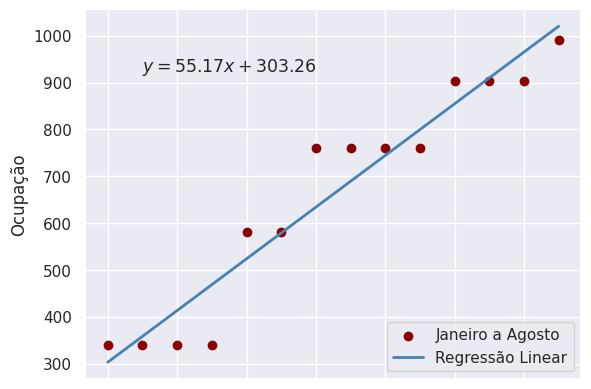

In [127]:
sns.set_theme()
fig, ax = plt.subplots()
ax.scatter(x_err, y_err, color='darkred', label='Janeiro a Agosto')
ax.plot(x_err, err_coefs[0]*x_err + err_coefs[1], color='steelblue', linewidth=2, label='Regressão Linear')
plt.text(1,925, f'$y = {err_coefs[0]:.2f}x + {err_coefs[1]:.2f}$', size=12.5)
plt.legend(loc='lower right')
ax.set_ylabel('Ocupação')
ax.set_xticklabels([])
plt.show()

Agora vamos adicionar os registros de Setembro em diante.

In [128]:
new_y = [np.NaN for i in err_jan_ago] + err_set_dez

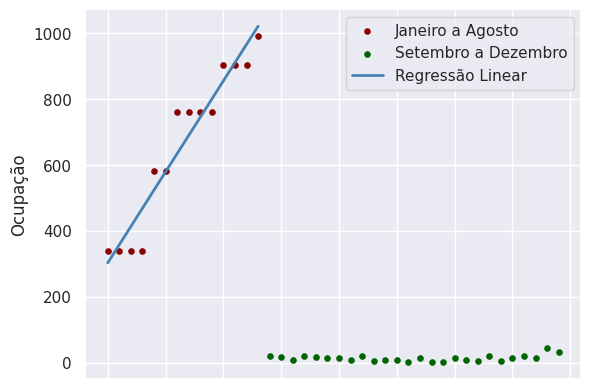

In [129]:
fig, ax = plt.subplots()
ax.scatter(x_err, y_err, s=14, color='darkred', label='Janeiro a Agosto')
ax.scatter(np.arange(len(err_jan_ago + err_set_dez)), new_y, s=14, color='darkgreen', label='Setembro a Dezembro')
ax.plot(x_err, err_coefs[0]*x_err + err_coefs[1], color='steelblue', linewidth=2, label='Regressão Linear')
plt.legend(loc='upper right')
ax.set_ylabel('Ocupação')
ax.set_xticklabels([])
plt.show()

Vemos que os pontos verdes (dados corretos) estão muito **distantes** da linha traçada pela regressão. Esta situação configura **presença da anomalia** que buscamos.

Agora, faremos o mesmo processo para um conjunto de dados correto, onde o conjunto *Set-Dez* deve estar bem próximo do esperado de acordo com os dados de *Jan-Ago*.

In [130]:
x_norm = np.arange(len(norm_jan_ago))
y_norm = norm_jan_ago
norm_coefs = np.polyfit(x_norm, y_norm, 1)
new_y = [np.NaN for i in norm_jan_ago] + norm_set_dez

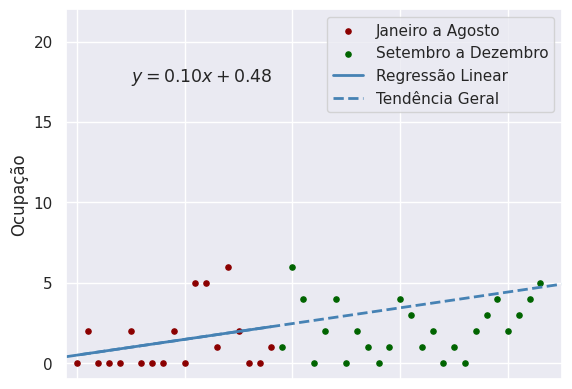

In [131]:
fig, ax = plt.subplots()
ax.scatter(x_norm, y_norm, s=14, color='darkred', label='Janeiro a Agosto')
ax.scatter(np.arange(len(norm_jan_ago + norm_set_dez)), new_y, s=14, color='darkgreen', label='Setembro a Dezembro')
ax.plot(x_norm, norm_coefs[0]*x_norm + norm_coefs[1], color='steelblue', linewidth=2, label='Regressão Linear')
ax.axline((20, np.polyval(norm_coefs, 20)), (44, np.polyval(norm_coefs, 44)), linestyle='--', color='steelblue', \
          linewidth=2, label='Tendência Geral')
ax.set_ylabel('Ocupação')
ax.set_xticklabels([])
plt.axis([-1, 45, -1, 22])
plt.legend(loc='upper right')
plt.text(5,17.5, f'$y = {norm_coefs[0]:.2f}x + {norm_coefs[1]:.2f}$', size=12.5)
plt.show()

> Os dados aqui parecem estar mais dispersos por causa da diferença de escala dos gráficos. Observe os valores do eixo "y".

Lembrando que a linha de regressão obtida nos mostra **apenas uma tendência geral** dos dados. Se nosso objetivo fosse fazer uma *predição*, seria melhor recorrer a *modelos mais avançados*. Como estamos apenas tentando identificar uma anomalia nos dados, este método pode ser útil.

Talvez uma reta não descreva tão bem o comportamento dos dados. Aumentar a complexidade do polinômio pode ser uma opção para resolver isso. Mas por enquanto vamos seguir assim.

Agora o que nos resta é decidir os parâmetros para qualificar um registro como normal ou não.

Podemos calcular um **intervalo de confiança** ou estabelecer algum **limite** para valores individuais utilizando a equação da reta como base. Aqui começamos a encontrar algumas questões, principalmente sobre *quais parâmetros utilizar para separar dados normais de incorretos*.

Temos que lembrar que nossos dados não nos permitem assumir uma distribuição *t* ou normal. Como já vimos, segundo as estatísticas descritivas, os dados se aproximam mais de uma **distribuição positivamente distorcida**. Podemos verificar isso nos histogramas a seguir:

(array([26.,  4.,  2.,  4.,  4.]),
 array([  2. , 199.6, 397.2, 594.8, 792.4, 990. ]),
 <BarContainer object of 5 artists>)

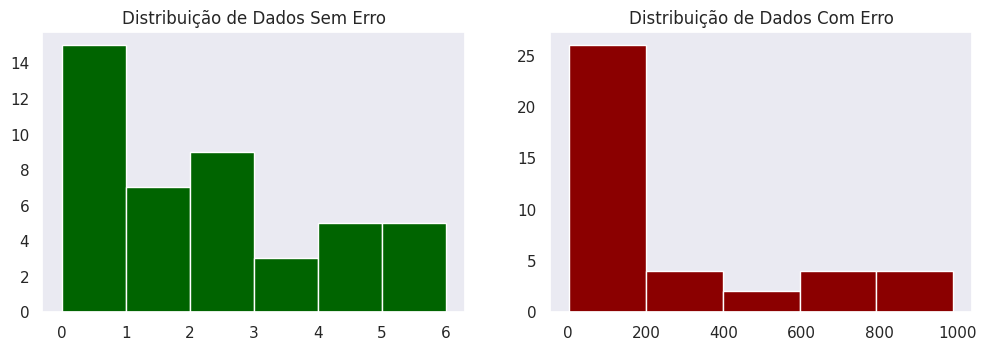

In [132]:
sns.set_style('dark')
# registros com erro Jan-Dez
err_full = pd.Series(err_jan_ago + err_set_dez)
# regitros normais Jan-Dez
norm_full = pd.Series(norm_jan_ago + norm_set_dez)
# gráficos
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,2,1, title='Distribuição de Dados Sem Erro')
plt.hist(norm_full, bins=(len(norm_full.unique())-1), color='darkgreen')
ax2 = fig.add_subplot(2,2,2, title='Distribuição de Dados Com Erro')
plt.hist(err_full, bins=int(len(err_full.unique())/4), color='darkred')

Nesta situação, para calcular o intervalo de confiança podemos usar um método *bootstrap*. Porém, **quantos pontos fora do intervalos são aceitáveis?** A partir de qual momento uma variação é considerada anormal? As mesmas questões permanecem se escolhessemos avaliar valores individuais com base na reta. 

Em ambos os métodos um **limite precisa ser estabelecido** entre o que é correto e o que é anormal. Além disso, **precisamos escolher o melhor método para calcular este limite**. São várias questões que precisam ser ponderadas.

Dependendo das escolhas, em uma situação onde dados *(ainda que corretos)* variem além do esperado, **poderiam ser incluídos como anômalos** dependendo do parâmetro escolhido.

Acredito que este método seja muito **superior ao anterior**, e caso não houvesse outras opções, seguiria com ele. Mas durante a avaliação um *detalhe* pareceu interessante. Na seção seguinte vamos explorar isso.

#### Diferença de Coeficientes Angulares<a id="12-a"></a>

Apesar do método anterior parecer bastante promissor, talvez algo *mais simples* também resolva o problema de maneira satisfatória. No final acaba sendo uma questão de escolha. Mas observe o seguinte.

Quando calculamos a regressão linear simples, talvez um polinômio mais complexo se ajustasse melhor aos dados. **Especialmente aos anômalos**.

**Podemos tirar proveito disso.**

Esta é a equação que descreveu os **registros anormais** de Janeiro a Agosto: $y=55.17x+303.26$

E esta, **registros normais** para o mesmo período: $y=0.10x+0.48$

Observe a **diferença entre os coeficientes** dos dois polinômios. Os coeficentes do polinômio resultante de dados anormais são cerca de **500 vezes maiores**. Claro que este pode ser um exemplo mais extremo, mas uma diferença assim nos mostra um ponto que pode ser explorado.

Naturalmente o *coeficiente linear* seria mais alto, uma vez que com o acumulo anormal das quantidades, valores muito maiores são gerados. Como já discutimos, os dados sobre saída são diferentes de dados sobre ocupação. Eles registram valores sobre eventos mais *pontuais*. Ou seja, um paciente recebe alta, isto é contabilizado, e acaba por aí. Por isso acabamos **observando valores mais baixos** quando tudo está em ordem.

Vamos testar isso com novos exemplos.

In [133]:
#cnes: 15644 - primeiro exemplo Excel
err_jan_ago = [132, 132, 132, 132, 132, 132, 181, 181, 181, 201, 201, 201]
err_set_dez = [1, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 5, 3]

#cnes: 5833418
norm_jan_ago = [0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 5, 5, 1, 6, 2, 0, 0, 1]
norm_set_dez = [1, 6, 4, 0, 2, 4, 0, 2, 1, 0, 1, 4, 3, 1, 2, 0, 1, 0, 2, 3, 4, 2, 3, 4, 5]

In [134]:
# anomalia - até agosto
x_err_1, y_err_1 = np.arange(len(err_jan_ago)), err_jan_ago
err_coefs_1 = np.polyfit(x_err_1, y_err_1, 1)

# anomalia - setembro em diante
x_err_2, y_err_2 = np.arange(len(err_set_dez)), err_set_dez
err_coefs_2 = np.polyfit(x_err_2, y_err_2, 1)
new_x_err, new_y_err = [len(x_err_1) + i for i in x_err_2], [np.NaN for i in err_jan_ago] + err_set_dez

# normal - até agosto
x_norm_1, y_norm_1 = np.arange(len(norm_jan_ago)), norm_jan_ago
norm_coefs_1 = np.polyfit(x_norm_1, y_norm_1, 1)

# normal - setembro em diante
x_norm_2, y_norm_2 = np.arange(len(norm_set_dez)), norm_set_dez
norm_coefs_2 = np.polyfit(x_norm_2, y_norm_2, 1)
new_x_norm, new_y_norm = [len(x_norm_1) + i for i in x_norm_2], [np.NaN for i in norm_jan_ago] + norm_set_dez

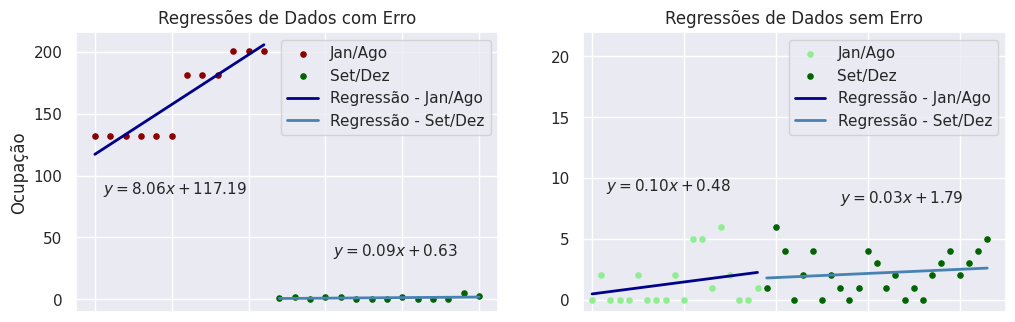

In [135]:
sns.set_theme()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,2,1, title='Regressões de Dados com Erro')
ax1.set_ylabel('Ocupação')
ax1.set_xticklabels([])
plt.scatter(x_err_1, y_err_1, s=14, color='darkred', label='Jan/Ago')
plt.scatter(np.arange(len(err_jan_ago + err_set_dez)), new_y_err, s=14, color='darkgreen', label='Set/Dez')
plt.plot(x_err_1, err_coefs_1[0]*x_err_1 + err_coefs_1[1], color='darkblue', linewidth=2, label='Regressão - Jan/Ago')
plt.plot(new_x_err, err_coefs_2[0]*x_err_2 + err_coefs_2[1], color='steelblue', linewidth=2, label='Regressão - Set/Dez')
plt.legend(loc='upper right')
plt.text(0.5, 85, f'$y = {err_coefs_1[0]:.2f}x + {err_coefs_1[1]:.2f}$', size=11)
plt.text(15.5, 35, f'$y = {err_coefs_2[0]:.2f}x + {err_coefs_2[1]:.2f}$', size=11)

ax2 = fig.add_subplot(2,2,2, title='Regressões de Dados sem Erro')
#ax2.set_ylabel('Ocupação')
ax2.set_xticklabels([])
plt.scatter(x_norm_1, y_norm_1, s=14, color='lightgreen', label='Jan/Ago')
plt.scatter(np.arange(len(norm_jan_ago + norm_set_dez)), new_y_norm, s=14, color='darkgreen', label='Set/Dez')
plt.plot(x_norm_1, norm_coefs_1[0]*x_norm_1 + norm_coefs_1[1], color='darkblue', linewidth=2, label='Regressão - Jan/Ago')
plt.plot(new_x_norm, norm_coefs_2[0]*x_norm_2 + norm_coefs_2[1], color='steelblue', linewidth=2, label='Regressão - Set/Dez')
plt.legend(loc='upper right')
plt.axis([-1, 45, -1, 22])
plt.text(1.5, 9, f'$y = {norm_coefs_1[0]:.2f}x + {norm_coefs_1[1]:.2f}$', size=11)
plt.text(27, 8, f'$y = {norm_coefs_2[0]:.2f}x + {norm_coefs_2[1]:.2f}$', size=11)
plt.show()

Junto a isso, em registros normais vemos um comportamento mais **estável**, sem grandes variações. É claro que devemos aceitar que em um momento ou outro pode haver um *pico de saídas*, mas algo assim **não alteraria tanto a angulação** da reta. E justamente por isso vemos uma diferença tão grande também nos **coeficientes angulares**.

Veja a **relação** entre coeficientes angulares de regressões lineares *Jan/Ago* e *Set/Dez*. Os valores mostram em que **ordem de grandeza** os coeficientes são diferentes.  

Registros **com erro**: $8.06 / 0.09 = 89.56$ 

Registros **sem erro**: $0.10 / 0.03 = 3.33$

Ou seja, neste teste, em registros contendo erro a diferença entre os coeficientes angulares foi de quase **90 vezes**. Enquanto em registros normais, aproximadamente **3 vezes**. 

Coeficientes angulares de registros anômalos sempre serão maiores. Depois de vários testes constatei que a **diferença é bem alta na maioria dos casos**. Dessa maneira fica *mais difícil de registros normais serem considerados anômalos*.

Este é um método mais **simples** que **evidencia bem a anomalia** que procuramos. Considerando isto, acredito que seja a **melhor escolha para a situação**. Sendo assim, nos resta escolher o limite para detecção.

Ainda aproveitando o exemplo, vamos utilizar os coeficientes angulares obtidos. Como nos registros normais os coeficientes angulares da regressão *Jan/Ago* se mostraram *3.3* vezes maiores do que *Set/Dez*, vamos utilizar algo *próximo disso* para exemplificar o método.

In [136]:
# o maior valor será designado para 'a'. O menor para 'b'
a_ok, b_ok = utils.big_small(norm_coefs_1[0], norm_coefs_2[0])
a_err, b_err = utils.big_small(err_coefs_1[0], err_coefs_2[0])

# testes com coeficientes - limite máximo aceitável: diferença de 3.5x
test_ok = "Sim" if np.allclose(a_ok, b_ok, rtol=2.5) else "Não"
test_err = "Sim" if np.allclose(a_err, b_err, rtol=2.5) else "Não"

# resultados
print(f"Teste com registros normais --> Coeficientes estão dentro do limite? {test_ok}\n\
Teste com registros anômalos --> Coeficientes estão dentro do limite? {test_err}")

Teste com registros normais --> Coeficientes estão dentro do limite? Sim
Teste com registros anômalos --> Coeficientes estão dentro do limite? Não


> ```np.allclose(a, b)``` utiliza a fórmula $abs(a-b) < (atol + rtol * abs(b))$ para retornar 'True' ou 'False'.

### Aplicando a Solução<a id="12-b"></a>

Após vários testes comparando registros normais e anômalos, percebi que um bom limite para separar os dois grupos é uma **diferença de no máximo 3.5 vezes** entre um e outro. Com essa condição alguns registros normais são detectados como anômalos, e para esses casos, estabeleci uma **tolerância absoluta de 1** entre os coeficientes angulares. Também determinei um **limite absoluto máximo para coeficientes**. *5* para *coeficiente* angular e *50* para *coeficiente* linear.

Com essa combinação a captura de registros anormais se mostrou bastante bastante refinada.

In [137]:
# listas temporárias para valores de saída / id de 'cnes' marcadas para exclusão
jan_ago, set_dez, drop_cnes = list(), list(), list()
# limite para separar datas em jan/ago e set/dez
sep_date = date(2020, 9, 1)

# suprime RankWarning - este aviso é sinalizado quando há poucos pontos para uma linha mais precisa
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    # itera por todas as cnes registradas
    for cnes in df['cnes'].unique():
        temp = df.loc[df['cnes'] == cnes].copy()
        # ordena registros por data -> mais recentes antes
        temp.sort_values(by='data', ascending=True, inplace=True)
        
        # separa registros em jan/ago e set/dez
        for i in range(len(temp)):
            if temp['data'].iloc[i] < sep_date:
                jan_ago.append(temp['totalSaidas'].iloc[i])
            else:
                set_dez.append(temp['totalSaidas'].iloc[i])
        # ajusta parâmetros para polyfit()
        x1 = np.arange(len(jan_ago))
        x2 = np.arange(len(set_dez))

        try:
            # inicializa variáveis para evitar NameError após possível TypeError
            coef_a1, coef_l1, coef_a2, coef_l2 = int(), int(), int(), int()
            # gera polinômios e seleciona coeficientes angulares
            coef_l1, coef_a1 = np.polynomial.polynomial.polyfit(x1, jan_ago, 1)
            coef_l2, coef_a2 = np.polynomial.polynomial.polyfit(x2, set_dez, 1)
        # TypeError é sinalizado quando um vetor vazio é fornecido como parâmetro para polyfit
        except TypeError:
            # apenas registros vazios
            if (not coef_a1) and (not coef_a2):
                utils.clear_lists(jan_ago, set_dez)
                continue
            # onde só há um conjunto, testa apenas o coeficiente angular presente
            if ((coef_a1) and (coef_a1 < 5)) or ((coef_a2) and (coef_a2 < 5)):
                utils.clear_lists(jan_ago, set_dez)
                continue
            # coeficiente angular maior que 5 -> marca para exclusão
            else: 
                drop_cnes.append(cnes)
                utils.clear_lists(jan_ago, set_dez)
                continue

        # valor absoluto máximo aceitável para coeficientes -> linear: 50 | angular: 5
        if (abs(coef_a1) >= 5) or (abs(coef_a2) >= 5) or (abs(coef_l1) >= 50) or (abs(coef_l2) >= 50):
            drop_cnes.append(cnes)
            utils.clear_lists(jan_ago, set_dez)
            continue

        # aplica teste entre coeficientes angulares jan/ago e set/dez -> tolerância de 3.5x (250%)
        a, b = utils.big_small(coef_a1, coef_a2)
        if np.allclose(a, b, rtol=2.5):
            utils.clear_lists(jan_ago, set_dez)
            continue
        else:
            # tolerância absoluta de 1 entre conjuntos recusados pelo teste anterior        
            if np.allclose(a, b, atol=1):
                utils.clear_lists(jan_ago, set_dez)
                continue      
            drop_cnes.append(cnes)
        # limpa listas para próximo loop
        utils.clear_lists(jan_ago, set_dez)

print(f'\nProcesso finalizado com {len(drop_cnes)} cnes marcadas para exclusão')


Processo finalizado com 58 cnes marcadas para exclusão


In [138]:
# pequena amostra de uma cnes com registros anormais
df.loc[(df['cnes'] == drop_cnes[5]), ['data', 'totalSaidas']]

,data,totalSaidas
66520,2020-06-11,60
67713,2020-06-12,60
68975,2020-06-13,60
69772,2020-06-14,60
71499,2020-06-15,60
...,...,...
532784,2020-12-26,1262
536501,2020-12-28,1269
539665,2020-12-29,1279
541633,2020-12-30,1286


In [139]:
# Verificação
print(f"Registros no DataFrame: {df.shape[0]}\n\
Quantidade de registros que serão excluídos:{len(df[df['cnes'].isin(drop_cnes)])}\n\
Total de registros após a operação: {df.shape[0] - len(df[df['cnes'].isin(drop_cnes)])}")

Registros no DataFrame: 554173
Quantidade de registros que serão excluídos:6128
Total de registros após a operação: 548045


In [140]:
# removendo registros de 'cnes' marcadas em 'drop_cnes'
df.drop(df.loc[df['cnes'].isin(drop_cnes)].index, inplace=True)
print(f"Remoções feitas -> Total de registros {df.shape[0]}")

Remoções feitas -> Total de registros 548045


In [141]:
# descomentar para salvar arquivo
#df.to_csv('ocupacao-leito-2020-fix.csv', index=False, encoding='utf-8')

# versão reduzida
#sample = df.sample(frac=0.35)
#sample.to_csv('ocupacao-leito-2020-fix-035.csv', index=False, encoding='utf-8')

#### Remanescentes<a id="12-c"></a>

A correção anterior foi **efetiva na remoção dos erros previstos**. Porém, ainda temos alguns pontos que chamam a atenção.

![erro na contagem de óbitos](https://github.com/lucascorumba/study-projects/blob/main/readme-imgs/covid-hospital-2020/count-err.png?raw=true)

Pela situação com as outras anomalias encontradas, imaginei que talvez houvessem erros semlhantes relacionados. No entanto, após uma verificação minuciosa não pude encontrar nada que pudesse ser dito como fora do normal. 

Já que não há erro, poderíamos concluir que na verdade é um *insigth* sobre a alta mortalidade do vírus especificamente no Rio Grande do Sul. Talvez pelas baixas temperaturas típicas da região ou alguma condição específica da população a enfermidade se mostra muito mais letal.

Mas na verdade nada disso pode ser afirmado. Na verdade as próprias medidas não podem dizer tanto assim. Desde o começo notei **algo estranho em registros de saída**. Como não era algo que afetasse o restante dos dados, decidi seguir até aqui para afirmar algo com mais certeza.

Observe o seguinte:

![contagem de ocupaçã e saídas](https://github.com/lucascorumba/study-projects/blob/main/readme-imgs/covid-hospital-2020/out-sum.png?raw=true)

Note como os campos ```totalOcupacao``` e ```totalSaidas``` se comportam. Pelo menos em teoria, o mais plausível seria que as **duas contagens variassem juntas**, mas logo vemos que não é o caso. No arquivo inteiro o padrão do exemplo se mantém.

Quando a **ocupação diminui**, supõe-se que **pacientes deixaram o hospital**. Ou seja, em toda redução em ```totalOcupacao```, haveria um **aumento proporcional** em ```totalSaidas```. Mas como visto, **não é o que acontece**. Temos um descompasso nas contagens, onde aparentemente **nem todas as saídas são registradas**.

Isso nos leva ao ponto da confiabilidade desta métrica, que já foi posta em questão uma vez que tivemos que intervir para corrigir [desvios críticos](#12). Não pela correção em si, mas pelo fato da correção ser necessária.

Na verdade, em relação a óbitos, os registros do Rio grande do Sul são na verdade os que mais se aproximam do que seria esperado (```totalSaidas``` é mais responsiva às reduções em ```totalOcupacao```). **As correções** feitas pelo [processo aplicado](#12-b) **não foram responsáveis por criar esta situação**, já que antes mesmo de ser aplicado os dados já mostravam esta particularidade. Isto pode ser verificado no [primeiro dashboard](#14-1), feito antes da aplicação.

Tendo tudo isso em vista podemo concluir que, por si só, as medidas de **saída** *podem nos trazer informações relevantes*, mas precisamos de **cautela** quando comparamos com medidas de **ocupação**.

Por exemplo, ainda podemos estudar a *variação de altas e óbitos ao longo dos meses* com certa confiança. Ou mesmo a relação entre *altas e óbitos*. Mas o mesmo não pode ser dito da relação entre *saídas e ocupação*.

Com isso em mente, vamos prosseguir.

Como feito antes, vamos verificar a correlação entre variáveis. Desta vez com os dados corrigidos.

In [142]:
df[cols].corr()

,ocupacaoSuspeitoCli,ocupacaoSuspeitoUti,ocupacaoConfirmadoCli,ocupacaoConfirmadoUti,saidaSuspeitaObitos,saidaSuspeitaAltas,saidaConfirmadaObitos,saidaConfirmadaAltas
ocupacaoSuspeitoCli,1.000000,0.610135,0.342722,0.311597,0.097240,0.126896,0.061358,0.150918
ocupacaoSuspeitoUti,0.610135,1.000000,0.483575,0.681331,0.187038,0.161327,0.170321,0.230529
ocupacaoConfirmadoCli,0.342722,0.483575,1.000000,0.679437,0.261519,0.379669,0.191620,0.379385
ocupacaoConfirmadoUti,0.311597,0.681331,0.679437,1.000000,0.268829,0.277373,0.229609,0.317228
saidaSuspeitaObitos,0.097240,0.187038,0.261519,0.268829,1.000000,0.244269,0.173327,0.103285
saidaSuspeitaAltas,0.126896,0.161327,0.379669,0.277373,0.244269,1.000000,0.096715,0.275248
saidaConfirmadaObitos,0.061358,0.170321,0.191620,0.229609,0.173327,0.096715,1.000000,0.288306
saidaConfirmadaAltas,0.150918,0.230529,0.379385,0.317228,0.103285,0.275248,0.288306,1.000000


# Visualização<a id="13"></a>

In [143]:
# alternativa para carregar dataframe com dados já tratados -- economiza processamento ao reiniciar o kernel
# df = pd.read_csv('ocupacao-leito-2020-fix.csv')

Temos os dados prontos. Salvando os arquivos já tratados, criamos a possibilidade de utilizar outras ferramentas para prosseguir com a análise. A seguir estão dois **dashboards** construídos com [Excel](#14-1) e [Google Sheets](#14-2). Os links para cada um deles estão disponiveis, mas neste notebook iremos utilizar visualizações feitas com a biblioteca [Seaborn](#15).

As seções [Modelo de regressão Linear Simples](#12-a1) e [Diferença de Coeficientes Angulares](#12-a) também possuem algumas visualizações interessantes explicando o processo aplicado na correção. Estas foram construídas apenas com **Matplotlib**.

## Planilhas<a id="14"></a>

### Inicial<a id="14-1"></a>

**[Este é o link para a primeira planilha no Excel Online](https://1drv.ms/x/s!Au47VyTboFIogl_WCrrFVhAwyH9p?e=5d3bos)**. No dashboard *(página "dash" da planilha)*, os dados podem ser **filtrados** por **Mês**, **Região** e **UF** simultâneamente para exploração dos dados como desejado.

Para contornar as limitações da versão online, foi utilizada a versão reduzida do dataset *(amostra com 35% dos dados)* para a construção das visualizações. 

A primeira página da planilha contém um dashboard interativo. As páginas seguintes contém o dataset e tabelas dinâmicas junto com suas respectivas visualizações. A maioria faz parte do dashboard, outras não foram incluídas.

**Com base nesta visualização foi possível detectar uma anomalia que passou desapercebida durante a fase de identificação de dados impróprios.** Mais sobre ela na seção [Correções Necessárias](#12).

![excel dashboard](https://github.com/lucascorumba/study-projects/blob/main/readme-imgs/covid-hospital-2020/excel-dashboard.png?raw=true)


A seguir encontra-se a versão atualizada com os dados corrigidos.

### Atualizada<a id="14-2"></a>

**[Este é o link para visualização da planilha no Google Sheets](https://docs.google.com/spreadsheets/d/1O2fglE8gcFNuHCOlKIajNJflBcbsEEOhqhN6wnGUEw8/edit?usp=sharing).** Assim como no Excel, aqui também estão incluídos filtros de **Mês**, **Região** e **UF**.

Da mesma maneira, também foi utilizada uma versão reduzida do dataset *(35%)* para construção das visualizações.
O dashboard está na primeira página *("dashboard")* da planilha. As páginas seguintes contém o dataset em si, tabelas dinâmicas e suas respectivas visualizações, todas com botões para filtragem personalizada.

![google sheets dashboard](https://github.com/lucascorumba/study-projects/blob/main/readme-imgs/covid-hospital-2020/google-sheets-dashboard.png?raw=true)

No dataset há um pequeno detalhe relativo às contagens de altas e óbitos. Após uma verificação minuciosa não encontrei nenhum erro como os anteriores. Esta particularidade se dá por possíveis imprecisões nas contagens. Mais sobre isso na seção [Remanescentes](#12-c).

## Seaborn<a id="15"></a>

## - - - - *em andamento* - - - -

Vamos começar verificando se podemos tirar informações interessantes de alguma correlação.

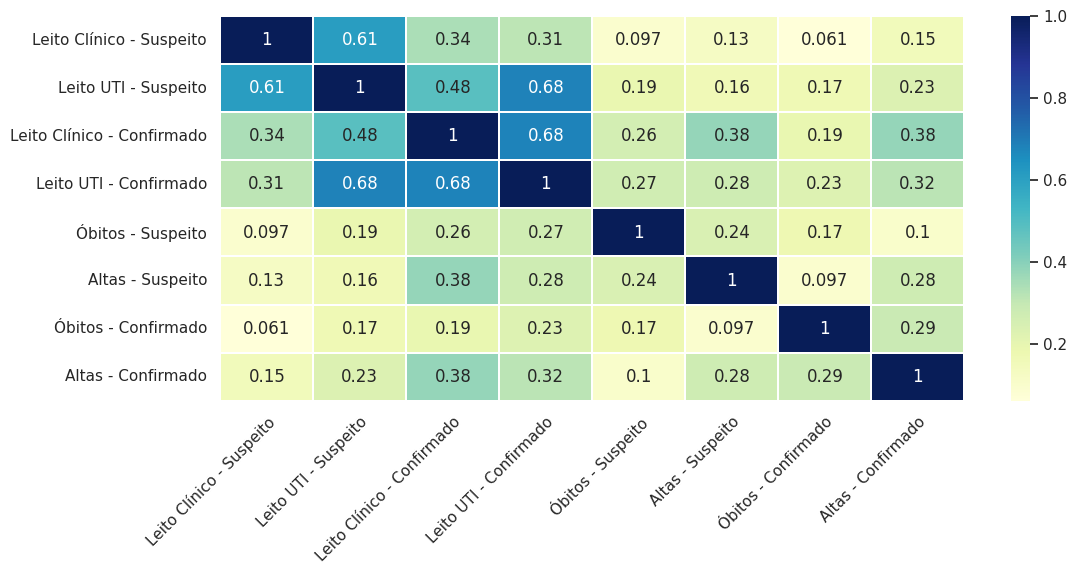

In [144]:
dict = {'ocupacaoSuspeitoCli': 'Leito Clínico - Suspeito', 'ocupacaoSuspeitoUti': 'Leito UTI - Suspeito',
'ocupacaoConfirmadoCli': 'Leito Clínico - Confirmado', 'ocupacaoConfirmadoUti': 'Leito UTI - Confirmado',
'saidaSuspeitaObitos': 'Óbitos - Suspeito', 'saidaSuspeitaAltas': 'Altas - Suspeito', 
'saidaConfirmadaObitos': 'Óbitos - Confirmado', 'saidaConfirmadaAltas': 'Altas - Confirmado'}
labels = [dict[col] for col in cols]
plt.figure(figsize=(12,5))
sns.heatmap(df[cols].corr(), cmap="YlGnBu", annot=True, linewidth=.3, xticklabels=labels, yticklabels=labels)
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
plt.show()

Versão reduzida, apenas com os totais:

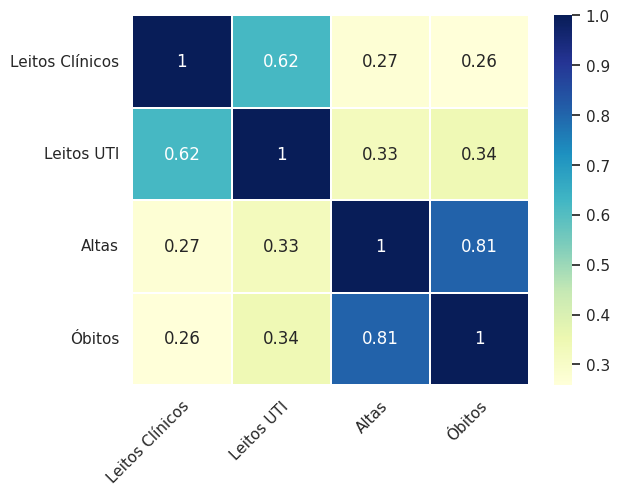

In [145]:
dict = {'totalOcupacaoCli': 'Leitos Clínicos', 'totalOcupacaoUti': 'Leitos UTI',
'totalAltas': 'Altas', 'totalObitos': 'Óbitos'}
totals = ['totalOcupacaoCli', 'totalOcupacaoUti', 'totalAltas', 'totalObitos']
labels = [dict[col] for col in totals]
sns.heatmap(df[totals].corr(), cmap="YlGnBu", annot=True, linewidth=.3, xticklabels=labels, yticklabels=labels)
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
plt.yticks(rotation=0)
plt.show()